# US electricity consumption and production analysis

## Get the data

In [24]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler

# Miscellaneous Libraries
import requests
import zipfile
import io
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams

import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

from colorama import Fore
from colorama import Style


plt.style.use('ggplot')


Notes:

Net generation excludes electricity use for power plant operations.
Terawatt hours, abbreviated as TWh, is a unit of energy representing one trillion watt hours.

Important links

[Electricity generation, capacity, and sales in the United States
](https://www.eia.gov/energyexplained/electricity/electricity-in-the-us-generation-capacity-and-sales.php#:~:text=In%202022%2C%20net%20generation%20of,solar%20photovoltaic%20(PV)%20systems.)

[Electricity data browser
](https://www.eia.gov/electricity/data.php)


Start with net generation data

#### Run the following packages to get Data

In [25]:
production_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.02'
consumption_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.03'
imports_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.04A'
exports_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T01.04B'
net_generation_url = 'https://www.eia.gov/totalenergy/data/browser/csv.php?tbl=T07.02A'

production = pd.read_csv(production_url)
consumption = pd.read_csv(consumption_url)
imports = pd.read_csv(imports_url)
exports = pd.read_csv(exports_url)
net_generation = pd.read_csv(net_generation_url)

In [26]:
net_generation_df = net_generation.pivot(index='YYYYMM', columns='Description', values='Value')
total_net_gen_df = net_generation_df.loc[:, ['Electricity Net Generation Total (including from sources not shown), All Sectors']]
production_df = production.pivot(index='YYYYMM', columns='Description', values='Value')
consumption_df = consumption.pivot(index='YYYYMM', columns='Description', values='Value')
imports_df = imports.pivot(index='YYYYMM', columns='Description', values='Value')
exports_df = exports.pivot(index='YYYYMM', columns='Description', values='Value')

In [27]:
merged_df = total_net_gen_df.merge(production_df, on='YYYYMM', how='left')
merged_df = merged_df.merge(consumption_df, on='YYYYMM', how='left')
merged_df = merged_df.merge(imports_df, on='YYYYMM', how='left')
df_train = merged_df.merge(exports_df, on='YYYYMM', how='left')
df_train = df_train.replace('Not Available',0)
df_train = df_train[~(df_train.index % 100 == 13)]
df_train.shape

(608, 44)

In [ ]:
y_df_gb = df_train['Electricity Net Generation Total (including from sources not shown), All Sectors']
x_df_gb = df_train.drop('Electricity Net Generation Total (including from sources not shown), All Sectors', axis = 1)

In [ ]:
x_df_gb_train, x_df_gb_test, y_df_gb_train, y_df_gb_test = train_test_split(x_df_gb, y_df_gb, test_size = 0.20, random_state = 0)

In [ ]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(x_df_gb, y_df_gb)

GradientBoostingRegressor(random_state=42)

In [ ]:
predictions_future = model.predict(x_df_gb)

In [ ]:
# Assuming 'df' is your DataFrame with real data
# Assuming 'dates_column' is the column containing dates
# Assuming 'y_real' is the column with the real values

# Plot real data
plt.plot(df_train['YYYYMM'], df_train['Electricity Net Generation Total (including from sources not shown), All Sectors'], label='Real Data', marker='o')

# Plot predictions
# Assuming 'dates_future' is the future dates associated with predictions
plt.plot(dates_future, predictions_future, label='Predictions', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Real Data vs Predictions')
plt.legend()
plt.show()


In [ ]:
numeric_columns = df_train.columns
df_train[numeric_columns] = df_train[numeric_columns].apply(pd.to_numeric, errors='coerce', downcast='float')

In [ ]:
var_columns = [c for c in df_train.columns if c not in ['YYYYMM','Electricity Net Generation Total (including from sources not shown), All Sectors']]
X = df_train.loc[:,var_columns]
y = df_train.loc[:,'Electricity Net Generation Total (including from sources not shown), All Sectors']

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2,random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((486, 43), (122, 43), (486,), (122,))

In [ ]:
train_summary = X_train.describe()
test_summary = X_valid.describe()


NameError: name 'X_train' is not defined

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predictions = model.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, predictions)
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 7902.716422049196, MSE: 100223523.2447376, R^2: 0.975865374606532


In [ ]:
# Assuming 'model' is your trained model
predictions_train = model.predict(X_train)
predictions_valid = model.predict(X_valid)

mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

mae_valid = mean_absolute_error(y_valid, predictions_valid)
mse_valid = mean_squared_error(y_valid, predictions_valid)
r2_valid = r2_score(y_valid, predictions_valid)

print("Training Set:")
print(f'MAE: {mae_train}, MSE: {mse_train}, R²: {r2_train}')

print("\nValidation Set:")
print(f'MAE: {mae_valid}, MSE: {mse_valid}, R²: {r2_valid}')


Training Set:
MAE: 3473.149625823034, MSE: 22982287.312519357, R²: 0.9957210689364531

Validation Set:
MAE: 7902.716422049196, MSE: 100223523.2447376, R²: 0.975865374606532


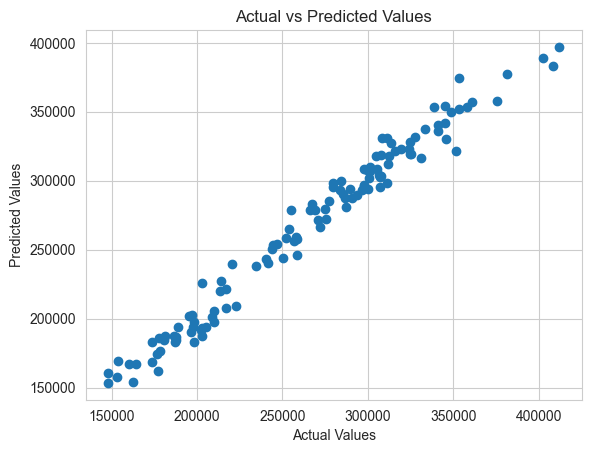

In [ ]:
plt.scatter(y_valid, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [ ]:
importances = model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                                              Feature  Importance
18                 Nuclear Electric Power Consumption    0.458168
7                   Nuclear Electric Power Production    0.404615
14                                   Coal Consumption    0.076719
22                   Total Primary Energy Consumption    0.006348
17  Natural Gas Consumption (Excluding Supplementa...    0.006329
29                                Electricity Imports    0.006074
8                             Solar Energy Production    0.004348
20                           Solar Energy Consumption    0.003576
3                        Geothermal Energy Production    0.003198
15                      Geothermal Energy Consumption    0.002424
28                                  Crude Oil Imports    0.002152
38                                Electricity Exports    0.001865
21                     Total Fossil Fuels Consumption    0.001594
32       Total Petroleum, Excluding Biofuels, Imports    0.001541
19        

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the validation set
gb_predictions = gb_model.predict(X_valid)

# Evaluate the model
gb_mae = mean_absolute_error(y_valid, gb_predictions)
gb_mse = mean_squared_error(y_valid, gb_predictions)
gb_r2 = r2_score(y_valid, gb_predictions)

print(f'Gradient Boosting - MAE: {gb_mae}, MSE: {gb_mse}, R^2: {gb_r2}')


Gradient Boosting - MAE: 7754.1235272252125, MSE: 96402926.09430431, R^2: 0.97678540493494


In [ ]:
from statsmodels.tsa.stattools import kpss

# Assuming 'y_train' is your target variable related to electricity generation
kpss_test_stat, kpss_p_value, _, kpss_critical_values = kpss(y_train)

# Display the test results
print(f'KPSS Test Statistic: {kpss_test_stat}')
print(f'p-value: {kpss_p_value}')
print('Critical Values:')
for key, value in kpss_critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if kpss_p_value < 0.05:
    print('\nThe training time series is non-stationary (reject the null hypothesis)')
else:
    print('\nThe training time series is stationary (fail to reject the null hypothesis)')


KPSS Test Statistic: 0.11052864375958518
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

The training time series is stationary (fail to reject the null hypothesis)


In [ ]:
df_train.set_index('YYYYMM',inplace = True)

In [ ]:
roll_mean = X_train.rolling(window=12, center=False).mean()
roll_std = X_train.rolling(window=12, center=False).std()

In [ ]:
import pandas as pd

# Assuming 'df_train' is your DataFrame
window_size = 12  # Adjust the window size as needed

# Apply rolling mean subtraction to each column
df_train_rolling_mean_subtracted = df_train.apply(lambda col: col - col.rolling(window=window_size).mean())

# Drop NaN values introduced by rolling mean calculation
df_train_rolling_mean_subtracted = df_train_rolling_mean_subtracted.dropna()

# Display the modified DataFrame
print(df_train_rolling_mean_subtracted.head())


Description  Electricity Net Generation Total (including from sources not shown), All Sectors  \
YYYYMM                                                                                          
197312.0                                          -1733.194667                                  
197401.0                                           2438.579833                                  
197402.0                                         -12301.799750                                  
197403.0                                          -4890.038083                                  
197404.0                                         -13147.460500                                  

Description  Biomass Energy Production  Coal Production  Crude Oil Production  \
YYYYMM                                                                          
197312.0                      0.002402        -0.016261              0.005132   
197401.0                      0.003300         0.078083             -0.014499

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
gb_grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_gb_params = gb_grid_search.best_params_
best_gb_model = gb_grid_search.best_estimator_

# Print the best parameters
print(f'Best Hyperparameters: {best_gb_params}')

# Make predictions using the best model
best_gb_predictions = best_gb_model.predict(X_valid)

# Evaluate the best model
best_gb_mae = mean_absolute_error(y_valid, best_gb_predictions)
best_gb_mse = mean_squared_error(y_valid, best_gb_predictions)
best_gb_r2 = r2_score(y_valid, best_gb_predictions)

print(f'Best Gradient Boosting - MAE: {best_gb_mae}, MSE: {best_gb_mse}, R^2: {best_gb_r2}')


KeyboardInterrupt: 

First use all data to make a model. From there we can see what features we want to keep and forcast.

In [30]:
gbr = GradientBoostingRegressor(n_estimators = 500)

gbr.fit(x_df_gb_train,y_df_gb_train)

GradientBoostingRegressor(n_estimators=500)

In [31]:
y_pred = gbr.predict(x_df_gb_test)
print(y_pred)

[353251.72204657 173709.70466024 294298.57348576 283504.61655025
 189360.073442   169419.38517941 341762.44518231 280070.45563416
 232817.87349476 351296.1750323  355498.77945194 358257.01146688
 210834.10333305 299863.31179336 317486.22507276 300911.47072269
 359072.91680552 327256.75600406 352596.32177157 330306.11822352
 193733.02768446 253973.94146659 258660.68527433 310911.41345644
 255970.34761376 318436.66745457 231749.42080909 206840.54672234
 280580.70598749 305992.35108269 289596.83899726 299455.01897233
 355880.74137585 299951.80363104 203460.83287093 351440.4347284
 403125.48085281 313657.68761479 294263.32055564 345072.13612835
 271034.36736692 241481.42055252 150624.18573881 306359.2988321
 400462.951628   319224.1121581  360685.41172435 303135.30256004
 144691.86753125 374716.67615584 286183.57112487 388798.910046
 359732.41336562 224777.44614562 330339.58923755 214612.33343245
 341816.65513464 307048.75775138 150168.64066697 235455.62964639
 182591.9729163  253594.98899

In [32]:
mae = mean_absolute_error(y_pred, y_df_gb_test)
print(mae)

7227.116682279747


In [33]:
mae = mean_absolute_error(y_pred, y_df_gb_test)
mse = mean_squared_error(y_pred, y_df_gb_test)
r2 = r2_score(y_pred, y_df_gb_test)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 7227.116682279747, MSE: 93782726.60486394, R^2: 0.9812880902702767


In [34]:
feature_scores = pd.Series(gbr.feature_importances_, index = x_df_gb_train.columns).sort_values(ascending = False)
print(feature_scores)

Description
Nuclear Electric Power Consumption                                0.465538
Nuclear Electric Power Production                                 0.327493
Coal Consumption                                                  0.075238
Geothermal Energy Production                                      0.031991
Natural Gas Imports                                               0.022802
Solar Energy Production                                           0.014099
Wind Energy Consumption                                           0.011739
Solar Energy Consumption                                          0.011497
Total Primary Energy Consumption                                  0.007870
Wind Energy Production                                            0.005328
Electricity Imports                                               0.004504
Natural Gas Consumption (Excluding Supplemental Gaseous Fuels)    0.003633
Geothermal Energy Consumption                                     0.002525
Total Fossil 

Now take out the ones that are directly correlated with total electricity generation

In [35]:
df_train_v2 = total_net_gen_df.merge(production_df, on='YYYYMM', how='left')
df_train_v2 = df_train_v2.replace('Not Available',0)
df_train_v2 = df_train_v2[~(df_train_v2.index % 100 == 13)]
df_train_v2.shape

y_df_gb_v2 = df_train_v2['Electricity Net Generation Total (including from sources not shown), All Sectors']
v2_drops = ['Electricity Net Generation Total (including from sources not shown), All Sectors','Nuclear Electric Power Production']
x_df_gb_v2 = df_train_v2.drop(v2_drops, axis = 1)

x_train_v2, x_test_v2, y_train_v2, y_test_v2 = train_test_split(x_df_gb_v2, y_df_gb_v2, test_size = 0.20, random_state = 0)


In [36]:
gbr = GradientBoostingRegressor(n_estimators = 500)

gbr.fit(x_train_v2,y_train_v2)

GradientBoostingRegressor(n_estimators=500)

In [37]:
y_pred_v2 = gbr.predict(x_test_v2)
print(y_pred_v2)

[335922.03285268 174066.53116673 327114.31010197 326667.33346117
 188559.5751613  188616.03596799 329016.82590322 298563.33604244
 248707.73020695 348185.95566946 350703.49700731 331273.51290849
 199267.40671339 311118.71164155 331253.5302133  323613.37841639
 323840.40280626 325161.20660569 354283.79538357 340492.49791203
 189488.94725786 259404.49425287 294651.61472725 339099.42787364
 219952.8230593  321657.14245309 252787.40838764 202466.29925411
 262631.04080662 319025.40850118 304994.79851699 314388.85186954
 323582.21422934 278891.59483167 199098.94441013 333822.1070403
 355894.91659109 326190.44567506 348760.58772321 353775.32301758
 258542.33063913 244751.55029047 172034.03419446 316891.32346408
 391562.6584556  343120.8984292  353976.47597058 314701.58781789
 150281.71368379 364001.3346588  276478.54042362 342715.33744978
 341783.28949954 200220.17418517 397680.35349726 207749.21982503
 337779.95365542 308977.99680265 163620.89659707 238345.98972898
 193934.65536227 265850.22

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_v2 = mean_absolute_error(y_pred_v2, y_test_v2)
mse_v2 = mean_squared_error(y_pred_v2, y_test_v2)
r2_v2 = r2_score(y_pred_v2, y_test_v2)

print(f'MAE: {mae_v2}, MSE: {mse_v2}, R^2: {r2_v2}')

MAE: 18095.29371162854, MSE: 559428839.996842, R^2: 0.8845879576443336


In [39]:
feature_scores_v2 = pd.Series(gbr.feature_importances_, index = x_train_v2.columns).sort_values(ascending = False)
print(feature_scores_v2)

Description
Geothermal Energy Production            0.422378
Solar Energy Production                 0.372931
Wind Energy Production                  0.108862
Crude Oil Production                    0.025043
Biomass Energy Production               0.019393
Total Primary Energy Production         0.016700
Natural Gas Plant Liquids Production    0.009479
Hydroelectric Power Production          0.008203
Total Renewable Energy Production       0.005316
Coal Production                         0.004473
Total Fossil Fuels Production           0.003851
Natural Gas (Dry) Production            0.003372
dtype: float64


We dont want to use types of energy that are produced as electricity right away. Instead we want energy that has to be produced and then converted to electricity such as Coal, Natrual Gas, and crude oil.

In [40]:
df_train_v3 = total_net_gen_df.merge(production_df, on='YYYYMM', how='left')
df_train_v3 = df_train_v3.replace('Not Available',0)
df_train_v3 = df_train_v3[~(df_train_v3.index % 100 == 13)]
df_train_v3.shape

y_df_gb_v3 = df_train_v3['Electricity Net Generation Total (including from sources not shown), All Sectors']
v3_features = ['Crude Oil Production','Natural Gas Plant Liquids Production','Coal Production']
x_df_gb_v3 = df_train_v3[v3_features]

x_train_v3, x_test_v3, y_train_v3, y_test_v3 = train_test_split(x_df_gb_v3, y_df_gb_v2, test_size = 0.20, random_state = 0)


In [41]:
gbr = GradientBoostingRegressor(n_estimators = 500)

gbr.fit(x_train_v3,y_train_v3)

GradientBoostingRegressor(n_estimators=500)

In [42]:
y_pred_v3 = gbr.predict(x_test_v3)
print(y_pred_v3)

[316722.97336454 196773.3394206  335085.90572751 364419.12505109
 163311.12460558 171974.09919133 294087.83119791 298293.0981607
 244607.09543949 342127.88682978 277459.29822094 329456.87633556
 204334.14183401 318084.26088246 341318.77688143 319110.33774696
 367256.06163229 339374.244817   364927.26790053 360451.41964265
 148863.3404352  256718.40834206 282048.7758981  344812.83704722
 228312.44243861 312798.2556309  250341.27719197 182342.71470399
 237727.0782571  299560.40016516 345389.00200979 315340.75584506
 315744.02749527 265748.85184704 198060.85485075 323289.95902834
 354416.34722895 333593.1660239  328880.23667646 296102.25790418
 261245.15291086 215460.90374117 163145.45886595 305552.9631051
 366020.8205746  352170.49255662 324148.3508334  348327.55103784
 168734.32136603 335646.28390986 297679.53261363 363192.56240794
 371826.9579615  197941.47473066 345249.95547071 208618.32470938
 315320.98588841 295364.75092012 163330.30451826 258294.86783806
 225653.11098983 302511.169

In [43]:
mae_v3 = mean_absolute_error(y_pred_v3, y_test_v3)
mse_v3 = mean_squared_error(y_pred_v3, y_test_v3)
r2_v3 = r2_score(y_pred_v3, y_test_v3)

print(f'MAE: {mae_v3}, MSE: {mse_v3}, R^2: {r2_v3}')

MAE: 28171.835578351816, MSE: 1231283032.388635, R^2: 0.745376433283117


With a r2 value of .74 that should be good enough for our analysis. 

Natural Gas Plant Liquids Production

# Modeling Natural Gas, Coal, and Oil

If we can model and forcast these three we can feed them back into our GradientBoostingRegressor to forcast Total US energy production.

## Natural Gas

We will use only from 2010 on becasue as we saw earlier in the EDA that is when the types of energy the US produces changes drastically.

In [44]:
nat_gas_prod = production_df['Natural Gas Plant Liquids Production']
nat_gas_prod = nat_gas_prod[~(nat_gas_prod.index % 100 == 13)]
nat_gas_prod.index = pd.to_datetime(nat_gas_prod.index, format='%Y%m')
nat_gas_prod = nat_gas_prod.astype(float)
nat_gas_prod = nat_gas_prod[nat_gas_prod.index >= '2010-01-01']
cutoff_nat_gas = round(nat_gas_prod.shape[0]*0.8)

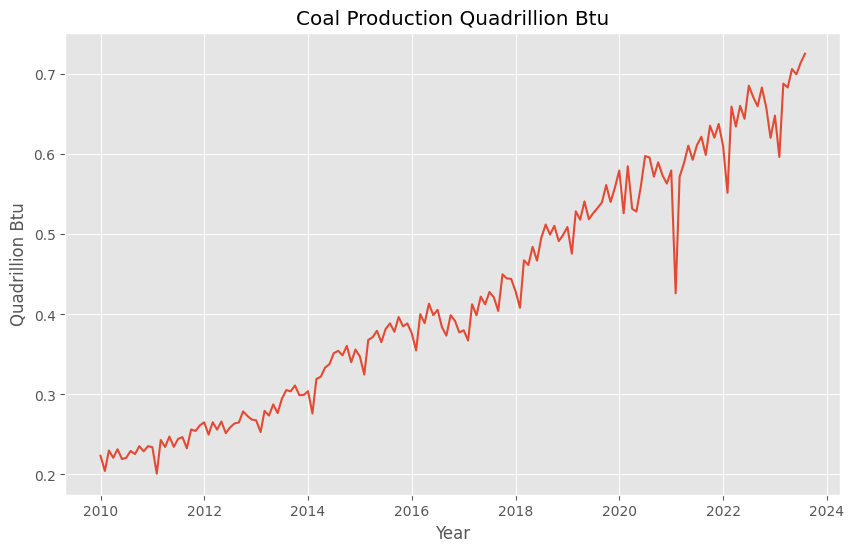

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=nat_gas_prod)
plt.title("Natural Gas Production Quadrillion Btu")
plt.xlabel('Year')
plt.ylabel('Quadrillion Btu')
plt.grid(True)
plt.show()

### Train and split the data

In [46]:
train_nat_gas = nat_gas_prod[:(cutoff_nat_gas+1)]
test_nat_gas = nat_gas_prod[cutoff_nat_gas:]
test_nat_gas = test_nat_gas.astype(float)

Text(0, 0.5, 'Production Quadrillion Btu')

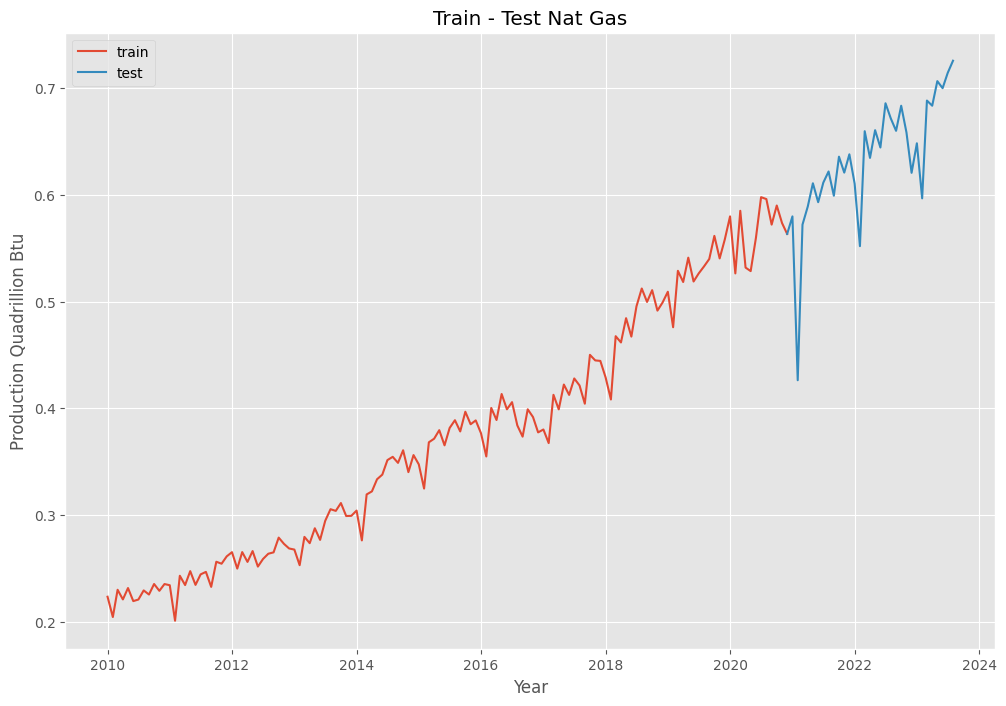

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_nat_gas, label='train')
ax.plot(test_nat_gas, label='test')
ax.set_title('Train - Test Nat Gas')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

### Validation Set

We use TimeSeriesSplit to so we have data that kept separate in order to validate our models.

In [48]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train_nat_gas):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] [44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65] [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87] [ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109]
[  0   1   2   3   4   5   6   

### Stationarity

We use a Dickey-Fuller test in order to see if there is there is is a trend  or Stationarity which is realted to the consistency of mean, cariance, and autocorrelation overtime.

In [50]:
dftest_nat_gas = adfuller(train_nat_gas)

# Extract and display test results in a user friendly manner
dfoutput_nat_gas = pd.Series(dftest_nat_gas[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_nat_gas[4].items():
    dfoutput_nat_gas['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput_nat_gas)

Results of Dickey-Fuller test: 

Test Statistic                   0.654975
p-value                          0.988895
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


Clearly not stationary the p-value is .98

### Series Decomposition

Using decomposition we can pull out the trend, and seasonality apart and display them. Leaving the residual which we will test next.

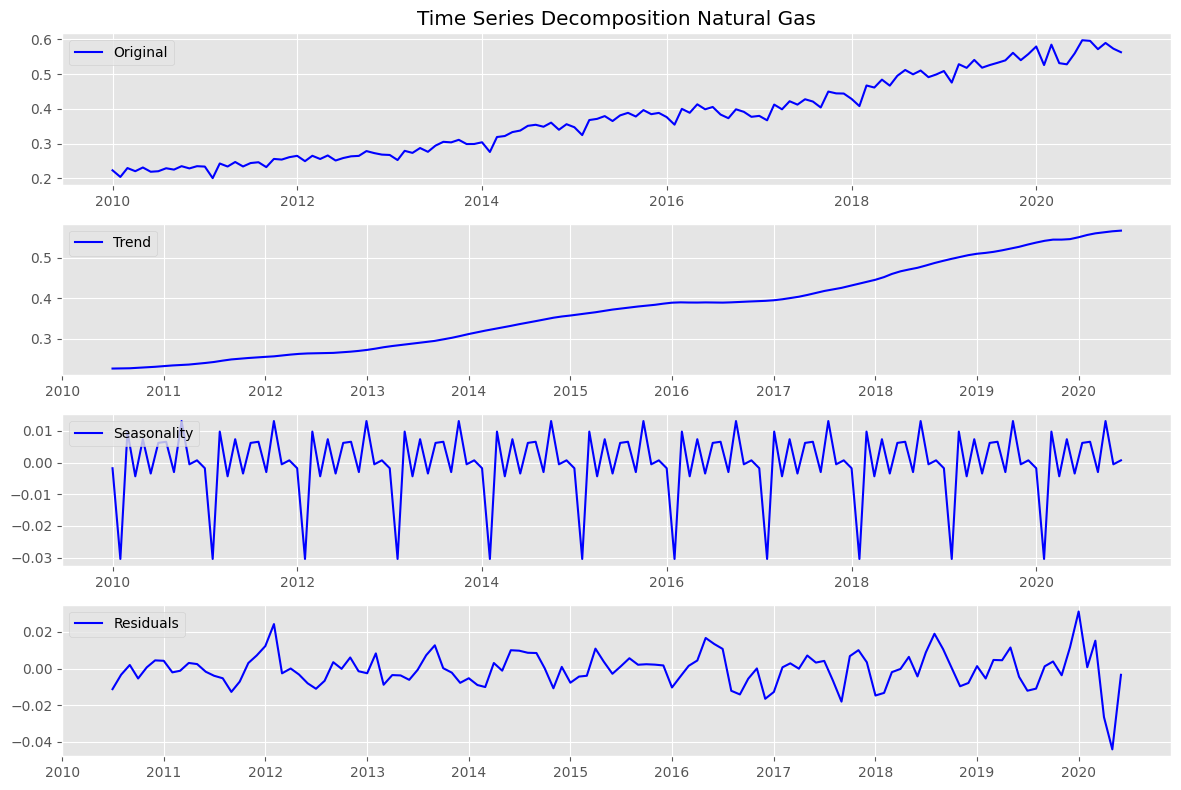

In [58]:
decomposition = seasonal_decompose(train_nat_gas)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(train_nat_gas, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='upper left')

plt.tight_layout();

Test it to make sure we have stationarity.

In [59]:
residual.dropna(inplace=True)

In [60]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -7.721978e+00
p-value                        1.185983e-11
#Lags Used                     5.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


the p-value is under .05 so we are good to go.

### Autocorrelation

Autocorrelation will reveal the stength and direction of linear relationships between observations. As pointed out in the EDA from above the production of energy is very seasonal.

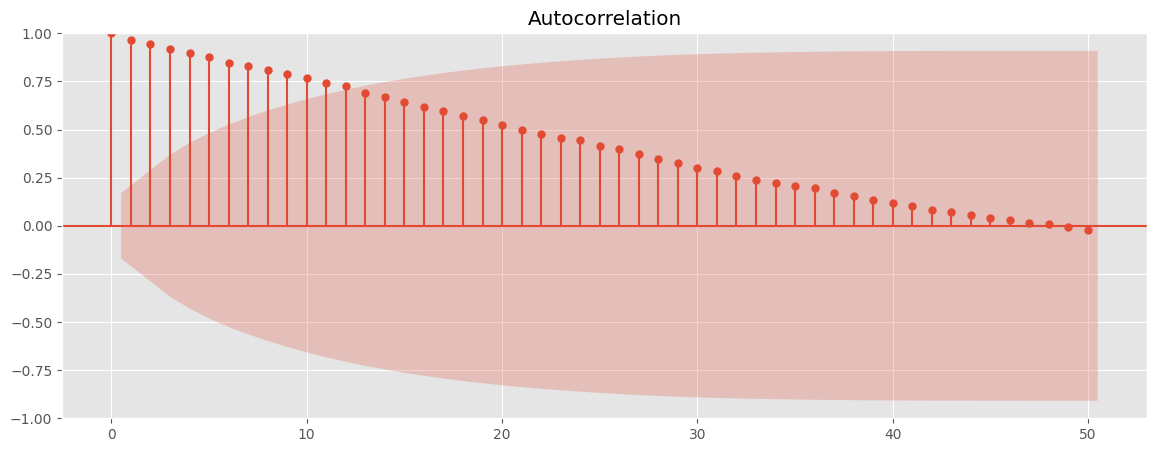

In [61]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train_nat_gas, lags=50);

In [62]:
nat_diff = train_nat_gas.diff(periods=1)
nat_diff.dropna(inplace=True)

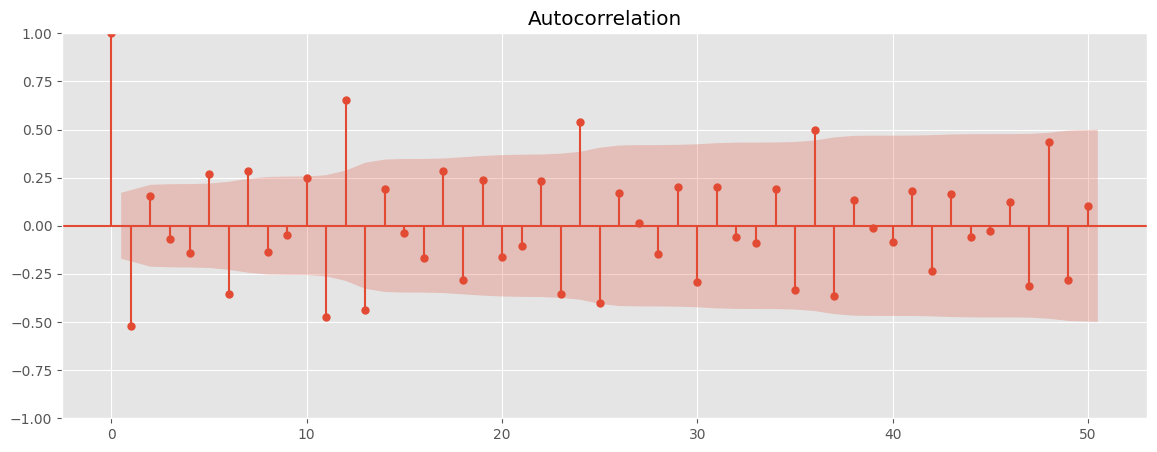

In [63]:
rcParams['figure.figsize'] = 14, 5
plot_acf(nat_diff, lags=50);

when we took out the first period we can now see lots of correlations with 12,24 and 36 months or 1,2, and  years.

### Baseline Model

Make a native model so we can have a base line. All we have to do is shit the data by one period.

In [66]:
naive = train_nat_gas.shift(1)
naive

YYYYMM
2010-01-01         NaN
2010-02-01    0.223423
2010-03-01    0.204401
2010-04-01    0.229944
2010-05-01    0.220908
                ...   
2020-08-01    0.597857
2020-09-01    0.596061
2020-10-01    0.572131
2020-11-01    0.590024
2020-12-01    0.573601
Name: Natural Gas Plant Liquids Production, Length: 132, dtype: float64

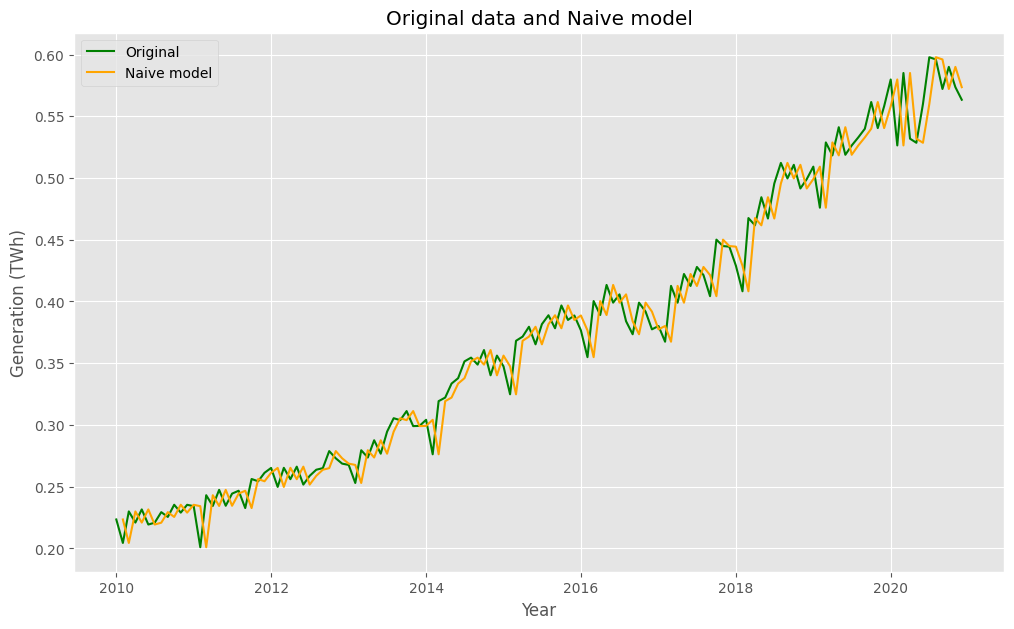

In [67]:
fig = plt.figure(figsize=(12,7))
plt.plot(train_nat_gas, color='green', label='Original')
plt.plot(naive, color='orange', label='Naive model')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show(block=False)

We will use Root Mean Squared Error to calculate the mean error between the value predicted and the real ones. The lower the better. 

In [68]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train_nat_gas[1:], naive.dropna())),2)
print(f'The RMSE for the naive baseline model is in TWh: {RMSE_naiv}')

The RMSE for the naive baseline model is in TWh: 0.02


### ARMA model


The ARMA (AutoRegressive Moving Average) model is a class of time series models that combines autoregressive (AR) and moving average (MA) components. p represents the order of the autoregressive (AR) component. d represents the number of times the series is differenced to achieve stationarity.q represents the order of the moving average (MA) component.

We can try some combinations of p,d,q and see what we get. We will look for AIC and RMSE to indicate how each combination is for our data. AIC is a measure of the goodness of fit of a statistical model. RMSE is a measure of the average magnitude of the errors between predicted and observed values.

### AR model

In [165]:
aics=[]
rmses=[]

def find_rmse(model, train_data=train_nat_gas):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [166]:
mod_ar = ARIMA(train_nat_gas, order=(1,0,0))
res_ar = mod_ar.fit()
aics.append(['armd', res_ar.aic])
rmses.append(['armd',find_rmse(res_ar)] )

### Random Walk

In [167]:
rw = ARIMA(train_nat_gas, order=(0,1,0))
res_rw = rw.fit()
aics.append(['rwlk', res_rw.aic])
rmses.append(['rwlk',find_rmse(res_rw)] )

### AR with First difference

In [168]:
mod_arfd = ARIMA(train_nat_gas, order=(1,1,0))
res_arfd = mod_arfd.fit()
aics.append(['arfd', res_arfd.aic])
rmses.append(['arfd',find_rmse(res_arfd)] )

### ARMA with first difference

In [169]:
mod_arma = ARIMA(train_nat_gas, order=(1,1,1))
res_arma = mod_arma.fit()
aics.append(['arma', res_arma.aic])
res_arma.aic
rmses.append(['arma',find_rmse(res_arma)] )

In [170]:
aics

[['armd', -644.7801735460655],
 ['rwlk', -647.2644949855925],
 ['arfd', -681.9270421545729],
 ['arma', -681.258487487073]]

In [171]:
rmses

[['armd', 0.024010249405837555],
 ['rwlk', 0.028057169209757],
 ['arfd', 0.026217570951258574],
 ['arma', 0.026157903619524706]]

### First ARIMA grid search 

211

In [95]:
mod_arma211 = ARIMA(train_nat_gas, order=(2,1,1))
res_arma211 = mod_arma211.fit()
aics.append(['arma211', res_arma211.aic])
rmses.append(['arma211',find_rmse(res_arma211)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


212

In [106]:
mod_arma212 = ARIMA(train_nat_gas, order=(2,1,2))
res_arma212 = mod_arma212.fit()
aics.append(['arma211', res_arma211.aic])
rmses.append(['arma212',find_rmse(res_arma212)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


214

In [112]:
mod_arma214 = ARIMA(train_nat_gas, order=(2,1,4))
res_arma214 = mod_arma214.fit()
aics.append(['arma214', res_arma214.aic])
rmses.append(['arfma214',find_rmse(res_arma214)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [245]:
mod_arma214 = ARIMA(train_nat_gas, order=(2, 1, 4))
res_arma214 = mod_arma214.fit()
aic_value = res_arma214.aic

print(f'AIC Value: {aic_value}')

AIC Value: -709.7885743303451


814

In [175]:
mod_arma814 = ARIMA(train_nat_gas, order=(8,1,4))
res_arma814 = mod_arma814.fit()
aics.append(['arma814', res_arma814.aic])
rmses.append(['arma814',find_rmse(res_arma814)] )

### Grid search for ARIMA model

A grid search will help us seach for the bes parameters for our model quickly.

In [232]:
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [177]:
warnings.filterwarnings("ignore")

### First grid search

In [241]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas, p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC=-197.875
ARIMA(0, 0, 1) AIC=-334.763
ARIMA(0, 0, 2) AIC=-434.556
ARIMA(0, 1, 0) AIC=-647.264
ARIMA(0, 1, 1) AIC=-680.040
ARIMA(0, 1, 2) AIC=-680.477
ARIMA(0, 2, 0) AIC=-499.426
ARIMA(0, 2, 1) AIC=-636.579
ARIMA(0, 2, 2) AIC=-682.395
ARIMA(1, 0, 0) AIC=-644.780
ARIMA(1, 0, 1) AIC=-676.826
ARIMA(1, 0, 2) AIC=-675.050
ARIMA(1, 1, 0) AIC=-681.927
ARIMA(1, 1, 1) AIC=-681.258
ARIMA(1, 1, 2) AIC=-679.337
ARIMA(1, 2, 0) AIC=-593.284
ARIMA(1, 2, 1) AIC=-674.988
ARIMA(1, 2, 2) AIC=-680.405
ARIMA(2, 0, 0) AIC=-678.791
ARIMA(2, 0, 1) AIC=-674.577
ARIMA(2, 0, 2) AIC=-673.800
ARIMA(2, 1, 0) AIC=-681.143
ARIMA(2, 1, 1) AIC=-679.162
ARIMA(2, 1, 2) AIC=-677.405
ARIMA(2, 2, 0) AIC=-623.359
ARIMA(2, 2, 1) AIC=-676.093
ARIMA(2, 2, 2) AIC=-671.026
ARIMA(4, 0, 0) AIC=-673.277
ARIMA(4, 0, 1) AIC=-676.111
ARIMA(4, 0, 2) AIC=-700.839
ARIMA(4, 1, 0) AIC=-681.388
ARIMA(4, 1, 1) AIC=-684.359
ARIMA(4, 1, 2) AIC=-677.224
ARIMA(4, 2, 0) AIC=-653.887
ARIMA(4, 2, 1) AIC=-682.864
ARIMA(4, 2, 2) AIC=-

The smaller the AIC the better so we will take ARIMA(4, 0, 2)

In [246]:
model_1stgrd = ARIMA(train_nat_gas, order=(0,1,0)).fit()

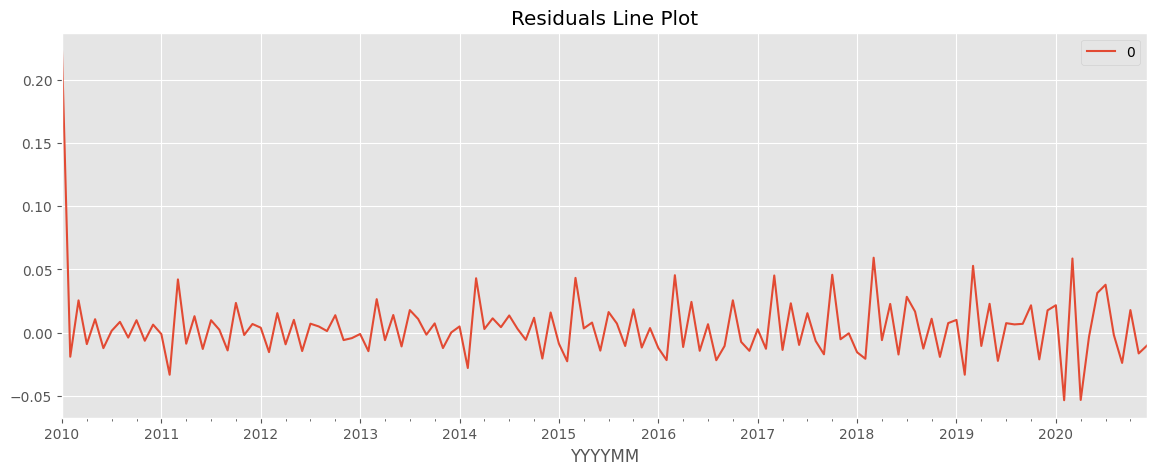

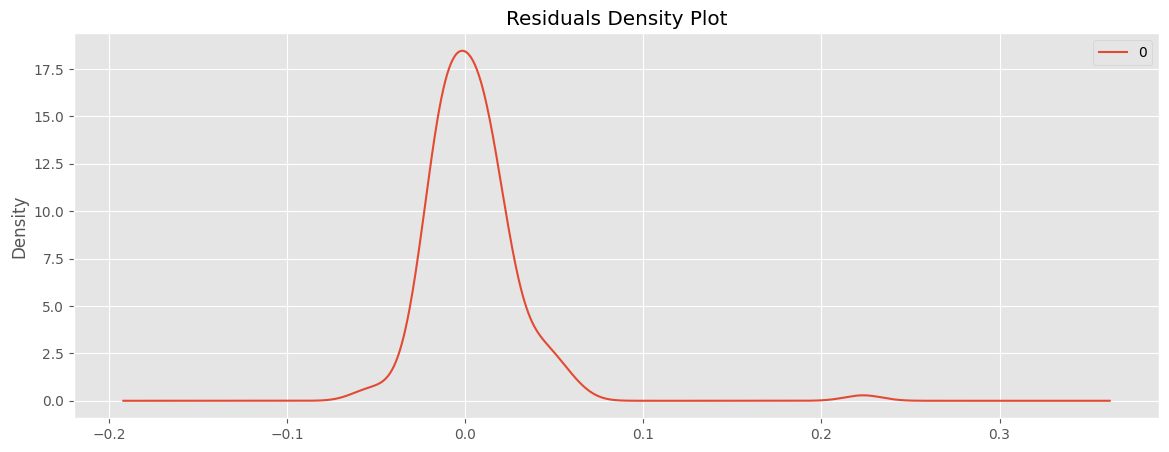

                0
count  132.000000
mean     0.004268
std      0.027836
min     -0.053428
25%     -0.011825
50%      0.002526
75%      0.013859
max      0.223423


In [247]:
# line plot of residuals
residuals = pd.DataFrame(model_1stgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test the data after the parameter turning to make sure is normally distributed and there is no seasonality

In [248]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -2.840358
p-value                          0.052736
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [249]:
print(f'{round(find_rmse(model_1stgrd),4)}')

0.0281


### Cross Validation

In [250]:
train_with_ind = train_nat_gas.reset_index()

In [251]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    #fitting on the train from the train-validation split
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(8, 1, 2)).fit()
    #predicting on the validation part of the sample
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    #comparing validation and predictions on validation
    print(np.sqrt(mean_squared_error(true, preds)))

0.010581504266555746
0.03376251369486834
0.015588312004579158
0.06399910387912713
0.06226135311807862


In [252]:
print(round(np.mean(cv),4))

0.036


We can do a second grid search if we are not happy with our RMSE. It is the same process as before.

In [253]:
p_values = [8, 10, 12, 20]
d_values = [1, 2, 4]
q_values = [1, 2, 4]
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas.values, p_values, d_values, q_values)

ARIMA(8, 1, 1) AIC=-681.832
ARIMA(8, 1, 2) AIC=-697.834
ARIMA(8, 1, 4) AIC=-676.025
ARIMA(8, 2, 1) AIC=-678.780
ARIMA(8, 2, 2) AIC=-692.254
ARIMA(8, 2, 4) AIC=-674.791
ARIMA(8, 4, 1) AIC=-542.396
ARIMA(8, 4, 2) AIC=-598.812
ARIMA(8, 4, 4) AIC=-614.215
ARIMA(10, 1, 1) AIC=-685.284
ARIMA(10, 1, 2) AIC=-716.178
ARIMA(10, 1, 4) AIC=-701.667
ARIMA(10, 2, 1) AIC=-680.196
ARIMA(10, 2, 2) AIC=-699.939
ARIMA(10, 2, 4) AIC=-720.226
ARIMA(10, 4, 1) AIC=-613.270
ARIMA(10, 4, 2) AIC=-588.154
ARIMA(10, 4, 4) AIC=-632.420
ARIMA(12, 1, 1) AIC=-755.815
ARIMA(12, 1, 2) AIC=-756.799
ARIMA(12, 1, 4) AIC=-755.574
ARIMA(12, 2, 1) AIC=-747.735
ARIMA(12, 2, 2) AIC=-729.876
ARIMA(12, 2, 4) AIC=-743.989
ARIMA(12, 4, 1) AIC=-615.025
ARIMA(12, 4, 2) AIC=-627.304
ARIMA(12, 4, 4) AIC=-660.663
ARIMA(20, 1, 1) AIC=-753.947
ARIMA(20, 1, 2) AIC=-755.025
ARIMA(20, 1, 4) AIC=-751.686
ARIMA(20, 2, 1) AIC=-738.353
ARIMA(20, 2, 2) AIC=-732.070
ARIMA(20, 2, 4) AIC=-723.288
ARIMA(20, 4, 1) AIC=-592.830
ARIMA(20, 4, 2) AIC=-66

In [257]:
model_2ndgrd = ARIMA(train_nat_gas, order=(8, 4, 1)).fit()

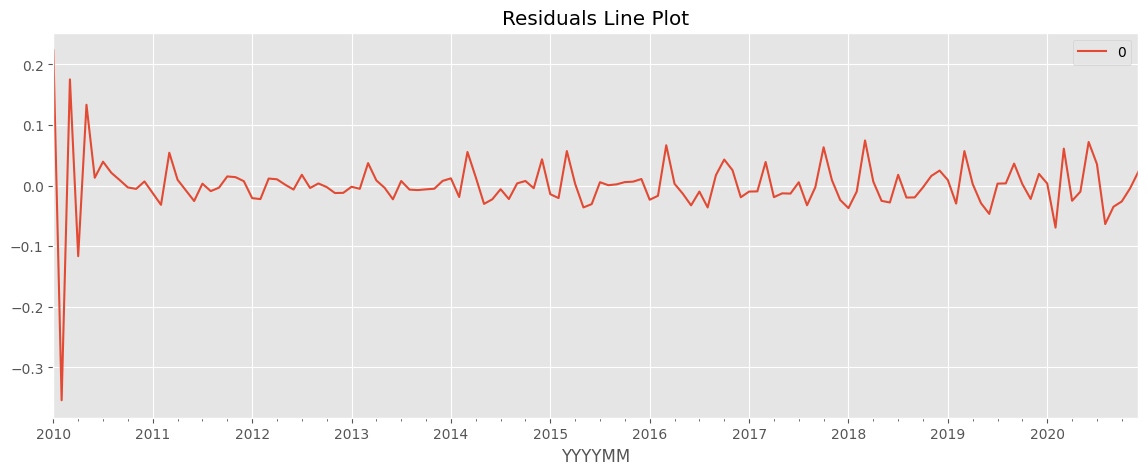

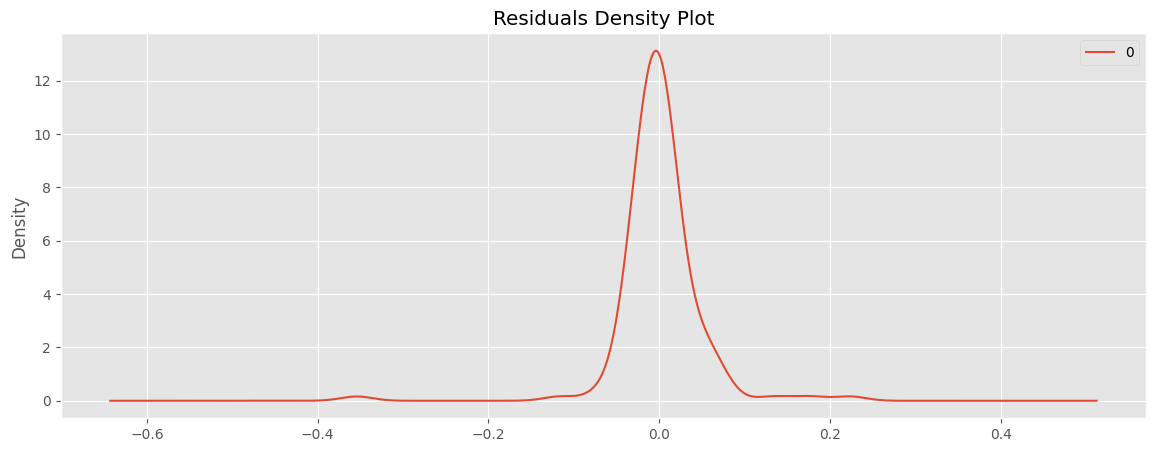

                0
count  132.000000
mean     0.000837
std      0.049782
min     -0.354157
25%     -0.019111
50%     -0.002501
75%      0.011740
max      0.223423


In [259]:
# line plot of residuals
residuals = pd.DataFrame(model_2ndgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [260]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.692970e+00
p-value                        4.065590e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


In [263]:
print(f'{Fore.BLUE}The RMSE for the best ARMA model after first grid, on the train, is in Qa Btu: {round(find_rmse(model_2ndgrd),2)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train, is in Qa Btu: 0.05


Cross Validation

In [264]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(12, 1, 4)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

0.019735624245068063
0.022410757317868492
0.015101416342244767
0.0681782164993922
0.01703831559059244


In [266]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in Qa Btu is: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in Qa Btu is: 0.03


SARIMAX model

We will use the SARIMAX model to take seasonality into account.

In [268]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm


In [269]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [270]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_nat_gas,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (1, 1, 1) x (1, 1, 1, 12): AIC Calculated=-619.0039398697127
ARIMA (1, 1, 1) x (1, 1, 2, 12): AIC Calculated=-538.8518635912495
ARIMA (1, 1, 1) x (1, 2, 1, 12): AIC Calculated=-502.7790515813464
ARIMA (1, 1, 1) x (1, 2, 2, 12): AIC Calculated=-430.04198416364966
ARIMA (1, 1, 1) x (1, 4, 1, 12): AIC Calculated=-276.8296041601161
ARIMA (1, 1, 1) x (1, 4, 2, 12): AIC Calculated=12.0
ARIMA (1, 1, 1) x (2, 1, 1, 12): AIC Calculated=-545.8962612090824
ARIMA (1, 1, 1) x (2, 1, 2, 12): AIC Calculated=-538.3342236281962
ARIMA (1, 1, 1) x (2, 2, 1, 12): AIC Calculated=-444.8702904647056
ARIMA (1, 1, 1) x (2, 2, 2, 12): AIC Calculated=-434.7986539676854
ARIMA (1, 1, 1) x (2, 4, 1, 12): AIC Calculated=-227.60588627888208
ARIMA (1, 1, 1) x (2, 4, 2, 12): AIC Calculated=14.0
ARIMA (1, 1, 1) x (4, 1, 1, 12): AIC Calculated=-389.29588439935935
ARIMA (1, 1, 1) x (4, 1, 2, 12): AIC Calculated=-387.57001191794706
ARIMA (1, 1, 1) x (4, 2, 1, 12): AIC Calculated=-300.2652172210217
ARIMA (1, 1, 1) x (

In [ ]:
ARIMA (1, 1, 1) x (1, 4, 2, 12): AIC Calculated=12.0

In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

In [ ]:
ans_df.to_pickle("./SARgrid1.pkl")

In [ ]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  

In [ ]:
res_grid_df.sort_values(by='aic').head(10)

Best model after grid search

In [ ]:
SARIMA_MODEL1 =SARIMAX(train_nat_gas, 
                        order=(8, 2, 2), 
                        seasonal_order=(8, 4, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model and print results
output1 = SARIMA_MODEL1.fit()

In [ ]:
output1.summary()

In [ ]:
y_hat_test = output2.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
y_hat_train = output2.get_prediction(start=pd.to_datetime('2001-01-01'), \
                        end=pd.to_datetime('2018-03-01'), dynamic=False, full_results=True)
pred_conf=y_hat_test.conf_int()

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(output1.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Cross Validation

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 2, 2), 
                    seasonal_order=(8, 4, 1, 12), 
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

In [ ]:
Second Grid Search SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [8, 12]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""CODE used for the second grid search

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_nat_gas,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
ans_df.to_pickle("./SARgs.pkl")

In [ ]:
results_df = pd.read_pickle("./SARgs.pkl")  

In [ ]:
results_df.sort_values(by='aic').head(10)

Best SARIMAX model 2nd grid search

In [ ]:
SARIMA_MODEL2 = SARIMAX(train, 
                        order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                        enforce_stationarity=True, 
                        enforce_invertibility=True)

# Fit the model and print results
output2 = SARIMA_MODEL2.fit()

output2.summary().tables[1]

In [ ]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=round(np.sqrt(mean_squared_error(train, y_hat_train2)),2)
print(f'{Fore.BLUE}RMSE of SARIMA model after second grid search : TWh {RMSE_train2}{Style.RESET_ALL}')

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(output2.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Cross Validation

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                     enforce_stationarity=True,
                     enforce_invertibility=True).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
mean=round(np.mean(cv),2)
print(f'{Fore.GREEN}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

Prediction on the test

fix dates

In [ ]:
y_hat_test = output2.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
y_hat_train = output2.get_prediction(start=pd.to_datetime('2001-01-01'), \
                        end=pd.to_datetime('2018-03-01'), dynamic=False, full_results=True)
pred_conf=y_hat_test.conf_int()

In [ ]:
nat_cut=nat['2010-01-01':]

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.plot(y_hat_test.predicted_mean, label='test_pred', color='b')
ax.plot(nat_cut, label='original data', color='g')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

In [ ]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='original data', color='g')
ax.plot(y_hat_test.predicted_mean, label='test pred', color='b')
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Generation (TWh)")
plt.legend();

RMSE on test

In [ ]:
rmse=round(np.sqrt(mean_squared_error(test_nat_gas, y_hat_test.predicted_mean)),3)
print(f'{Fore.BLUE}RMSE of our model on the test set in TWh: {rmse}{Style.RESET_ALL}')

In [ ]:
Forecasting

In [ ]:
final = SARIMAX(nat_gas_prod,
                  order=(8, 1, 2), 
                  seasonal_order=(12, 2, 1, 12), 
                  enforce_stationarity=True,
                  enforce_invertibility=True).fit()

In [ ]:
forecast = final.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = forecast.conf_int()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(nat_cut, label='observed')
ax.plot(forecast.predicted_mean, label='forecast')
ax.set_title('Natural Gas Forecasting next three years')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots()
ax.plot(test, label='observed')
ax.plot(forecast.predicted_mean, label='forecast')
ax.set_title('Natural Gas Forecasting next three years')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

In [ ]:
forecast.summary_frame()

In [ ]:
total=pd.concat([nat,fore['mean']])

In [ ]:
plt.title('Production of Natural Gas in the United States: real data and forecast')
plt.plot(total)
plt.xlabel("Year")
plt.ylabel("Generation (TWh)");

## Coal Production

In [ ]:
coal_prod = production_df['Coal Production']
coal_prod = coal_prod[~(coal_prod.index % 100 == 13)]
coal_prod.index = pd.to_datetime(coal_prod.index, format='%Y%m')
coal_prod = coal_prod.astype(float)
coal_prod = coal_prod[coal_prod.index >= '2010-01-01']
cutoff_coal = round(coal_prod.shape[0]*0.8)

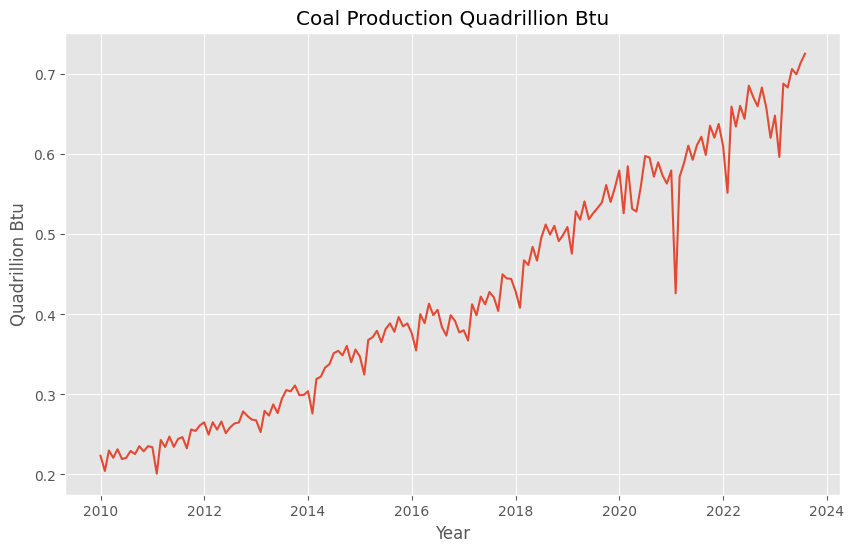

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=coal_prod)
plt.title("Coal Production Quadrillion Btu")
plt.xlabel('Year')
plt.ylabel('Quadrillion Btu')
plt.grid(True)
plt.show()

### Train and split the data

In [ ]:
train_coal = coal_prod[:(cutoff_coal+1)]
test_coal = coal_prod[cutoff_coal:]
test_coal = test_coal.astype(float)

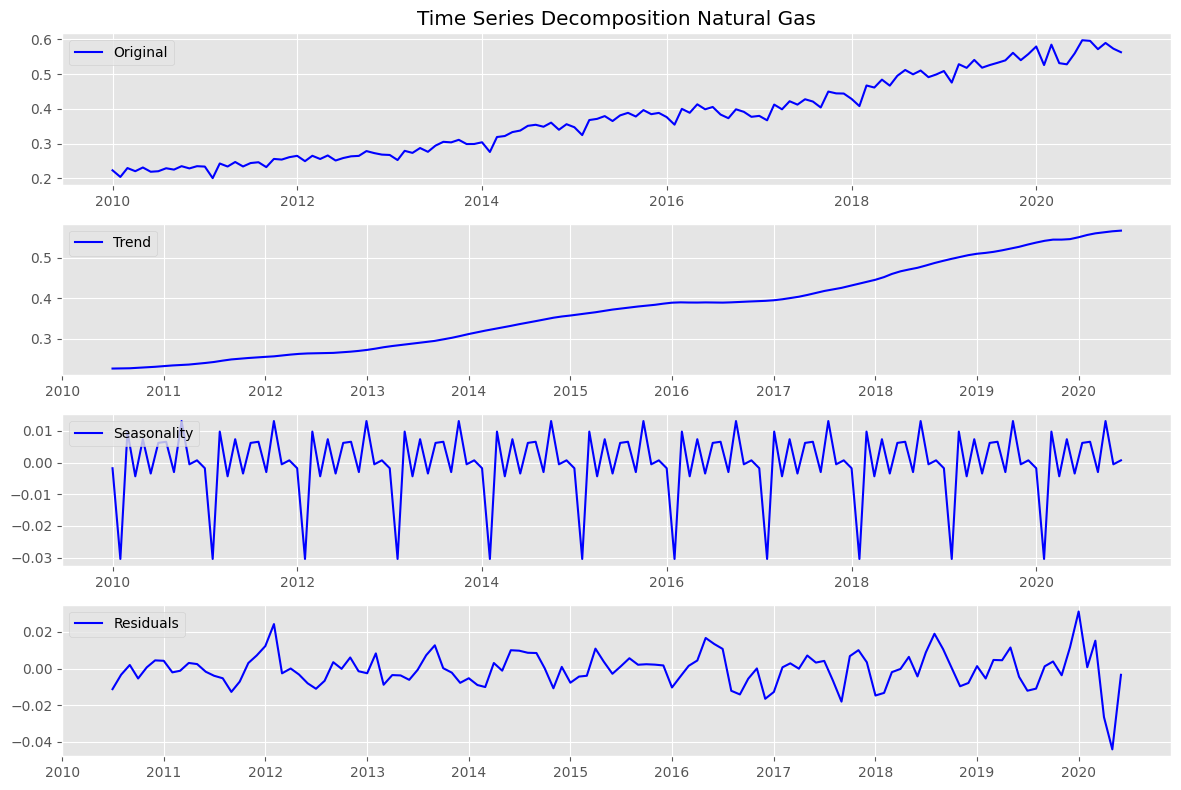

In [ ]:
decomposition = seasonal_decompose(train_coal)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Coal')
plt.plot(train_coal, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='upper left')

plt.tight_layout();

In [ ]:
residual.dropna(inplace=True)

In [ ]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -7.721978e+00
p-value                        1.185983e-11
#Lags Used                     5.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


### Autocorrelation

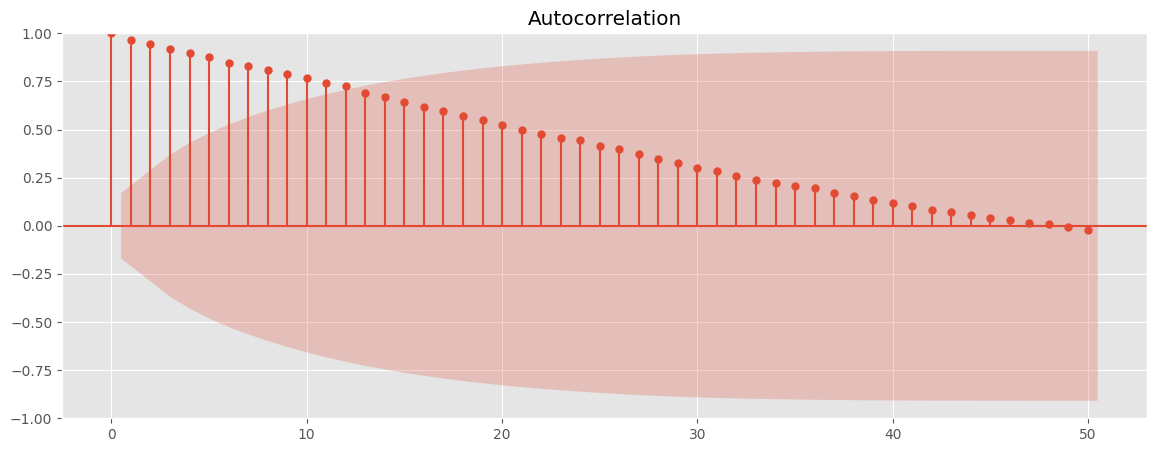

In [ ]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train_coal, lags=50);

In [ ]:
coal_diff = train_coal.diff(periods=1)
coal_diff.dropna(inplace=True)

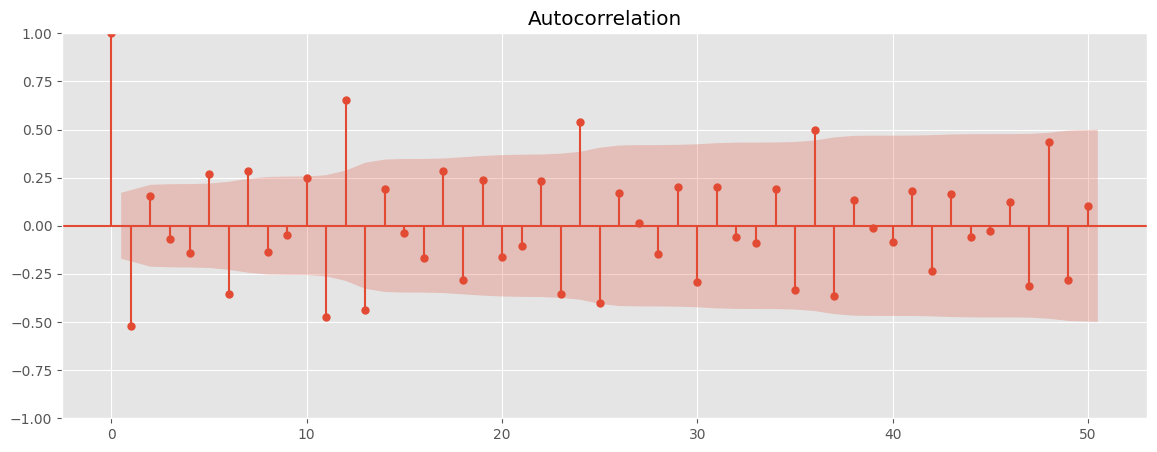

In [ ]:
rcParams['figure.figsize'] = 14, 5
plot_acf(coal_diff, lags=50);

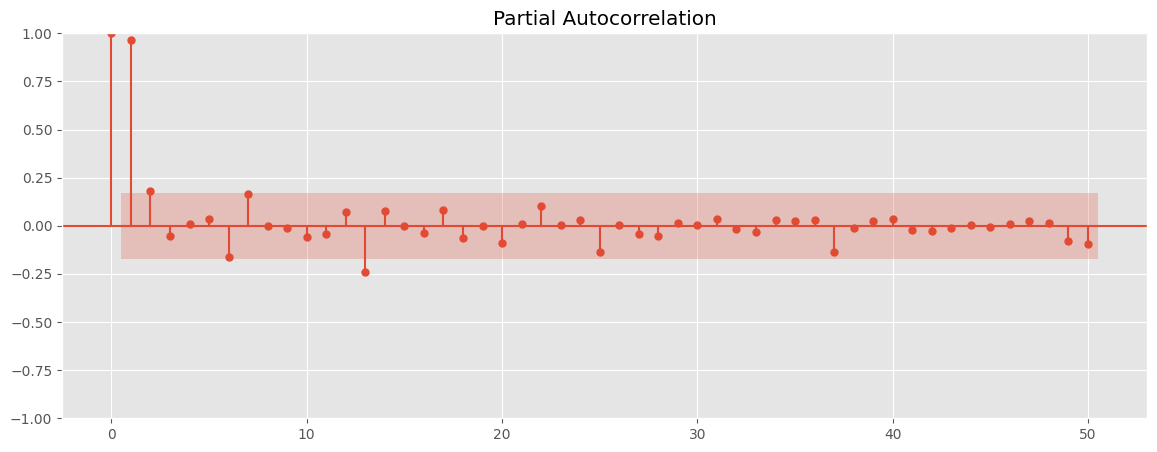

In [ ]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(train_coal, lags=50);

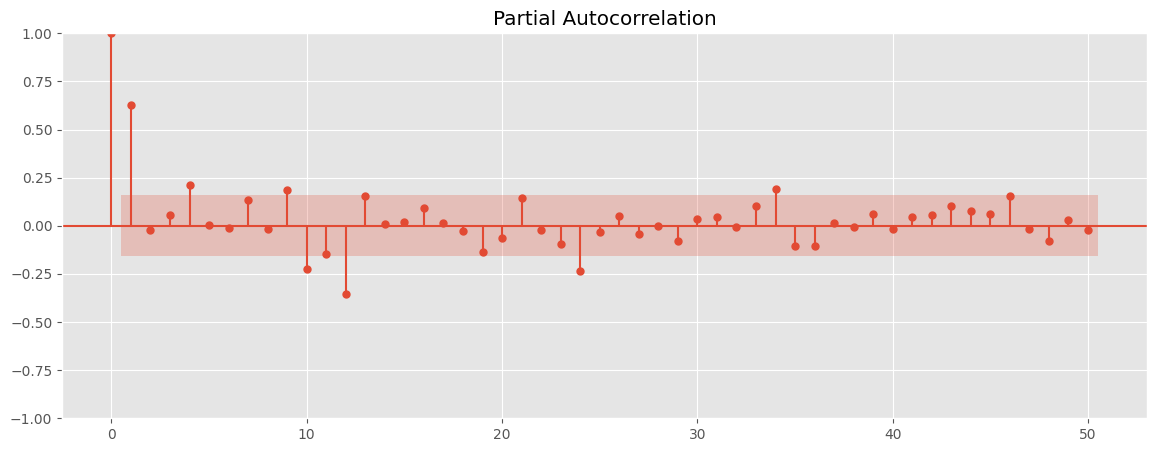

In [ ]:
coal_diff12 = coal_prod.diff(periods=12)
coal_diff12.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(coal_diff12, lags=50);

### Baseline Model

In [ ]:
naive = train_coal.shift(1)
naive

YYYYMM
2010-01-01         NaN
2010-02-01    0.223423
2010-03-01    0.204401
2010-04-01    0.229944
2010-05-01    0.220908
                ...   
2020-08-01    0.597857
2020-09-01    0.596061
2020-10-01    0.572131
2020-11-01    0.590024
2020-12-01    0.573601
Name: Natural Gas Plant Liquids Production, Length: 132, dtype: float64

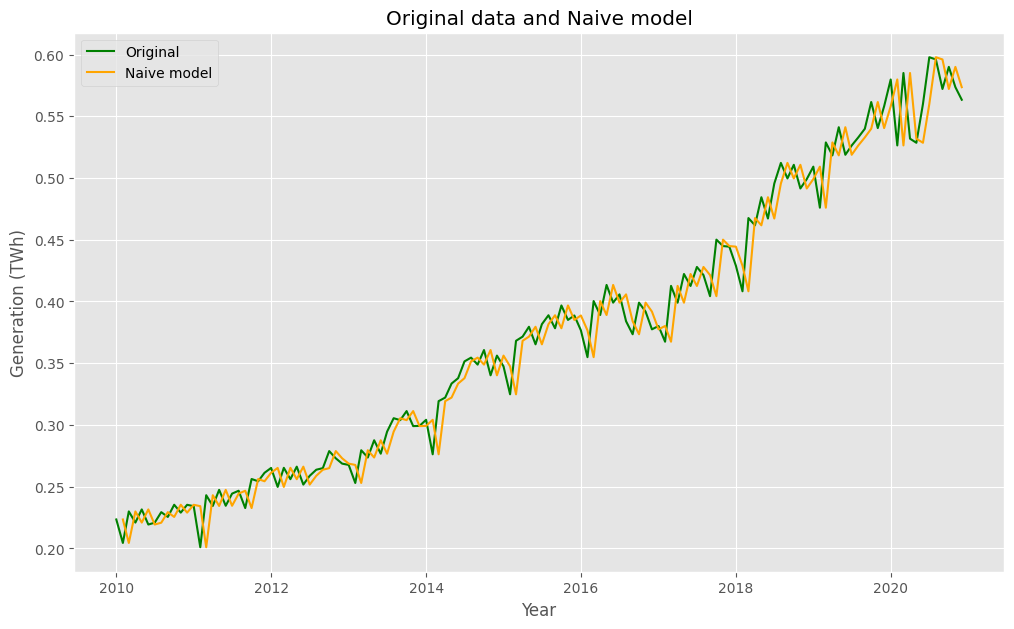

In [ ]:
fig = plt.figure(figsize=(12,7))
plt.plot(train_coal, color='green', label='Original')
plt.plot(naive, color='orange', label='Naive model')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.show(block=False)

In [ ]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train_coal[1:], naive.dropna())),2)
print(f'The RMSE for the naive baseline model is in TWh: {RMSE_naiv}')

The RMSE for the naive baseline model is in TWh: 0.02


### ARIMA model

### AR model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
aics=[]
rmses=[]

def find_rmse(model, train_data=train_nat_gas):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [ ]:
mod_ar = ARIMA(train_nat_gas, order=(1,0,0))
res_ar = mod_ar.fit()
aics.append(['armd', res_ar.aic])
rmses.append(['armd',find_rmse(res_ar)] )

### Random Walk

In [ ]:
rw = ARIMA(train_nat_gas, order=(0,1,0))
res_rw = rw.fit()
aics.append(['rwlk', res_rw.aic])
rmses.append(['rwlk',find_rmse(res_rw)] )

### AR with First difference

In [ ]:
mod_arfd = ARIMA(train_nat_gas, order=(1,1,0))
res_arfd = mod_arfd.fit()
aics.append(['arfd', res_arfd.aic])
rmses.append(['arfd',find_rmse(res_arfd)] )

### ARMA with first difference

In [ ]:
mod_arma = ARIMA(train_nat_gas, order=(1,1,1))
res_arma = mod_arma.fit()
aics.append(['arma', res_arma.aic])
res_arma.aic
rmses.append(['arma',find_rmse(res_arma)] )

In [ ]:
aics

[['armd', -644.7801735460655],
 ['rwlk', -647.2644949855925],
 ['arfd', -681.9270421545729],
 ['arma', -681.258487487073]]

In [ ]:
rmses

[['armd', 0.024010249405837555],
 ['rwlk', 0.028057169209757],
 ['arfd', 0.026217570951258574],
 ['arma', 0.026157903619524706]]

### First ARIMA grid search 

higher orders

211

In [ ]:
mod_arma211 = ARIMA(train_nat_gas, order=(2,1,1))
res_arma211 = mod_arma211.fit()
aics.append(['arma211', res_arma211.aic])
rmses.append(['arma211',find_rmse(res_arma211)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


212

In [ ]:
mod_arma212 = ARIMA(train_nat_gas, order=(2,1,2))
res_arma212 = mod_arma212.fit()
aics.append(['arma211', res_arma211.aic])
rmses.append(['arma212',find_rmse(res_arma212)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


214

In [ ]:
mod_arma214 = ARIMA(train_nat_gas, order=(2,1,4))
res_arma214 = mod_arma214.fit()
aics.append(['arma214', res_arma214.aic])
rmses.append(['arfma214',find_rmse(res_arma214)] )

C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nfs25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
mod_arma214 = ARIMA(train_nat_gas, order=(2, 1, 4))
res_arma214 = mod_arma214.fit()
aic_value = res_arma214.aic

print(f'AIC Value: {aic_value}')

AIC Value: -709.7885743303451


814

In [ ]:
mod_arma814 = ARIMA(train_nat_gas, order=(8,1,4))
res_arma814 = mod_arma814.fit()
aics.append(['arma814', res_arma814.aic])
rmses.append(['arma814',find_rmse(res_arma814)] )

### Grid search for ARIMA model

In [ ]:
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [ ]:
warnings.filterwarnings("ignore")

### First grid search

In [ ]:
p_values = [0,1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas, p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC=-197.875
ARIMA(0, 0, 1) AIC=-334.763
ARIMA(0, 0, 2) AIC=-434.556
ARIMA(0, 1, 0) AIC=-647.264
ARIMA(0, 1, 1) AIC=-680.040
ARIMA(0, 1, 2) AIC=-680.477
ARIMA(0, 2, 0) AIC=-499.426
ARIMA(0, 2, 1) AIC=-636.579
ARIMA(0, 2, 2) AIC=-682.395
ARIMA(1, 0, 0) AIC=-644.780
ARIMA(1, 0, 1) AIC=-676.826
ARIMA(1, 0, 2) AIC=-675.050
ARIMA(1, 1, 0) AIC=-681.927
ARIMA(1, 1, 1) AIC=-681.258
ARIMA(1, 1, 2) AIC=-679.337
ARIMA(1, 2, 0) AIC=-593.284
ARIMA(1, 2, 1) AIC=-674.988
ARIMA(1, 2, 2) AIC=-680.405
ARIMA(2, 0, 0) AIC=-678.791
ARIMA(2, 0, 1) AIC=-674.577
ARIMA(2, 0, 2) AIC=-673.800
ARIMA(2, 1, 0) AIC=-681.143
ARIMA(2, 1, 1) AIC=-679.162
ARIMA(2, 1, 2) AIC=-677.405
ARIMA(2, 2, 0) AIC=-623.359
ARIMA(2, 2, 1) AIC=-676.093
ARIMA(2, 2, 2) AIC=-671.026
ARIMA(4, 0, 0) AIC=-673.277
ARIMA(4, 0, 1) AIC=-676.111
ARIMA(4, 0, 2) AIC=-700.839
ARIMA(4, 1, 0) AIC=-681.388
ARIMA(4, 1, 1) AIC=-684.359
ARIMA(4, 1, 2) AIC=-677.224
ARIMA(4, 2, 0) AIC=-653.887
ARIMA(4, 2, 1) AIC=-682.864
ARIMA(4, 2, 2) AIC=-

In [ ]:
model_1stgrd = ARIMA(train_nat_gas, order=(0,1,0)).fit()

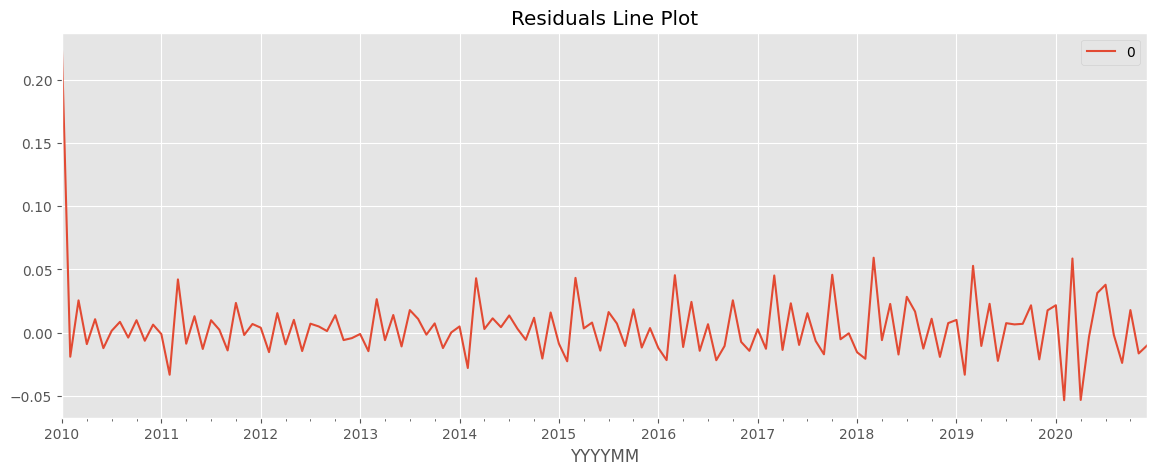

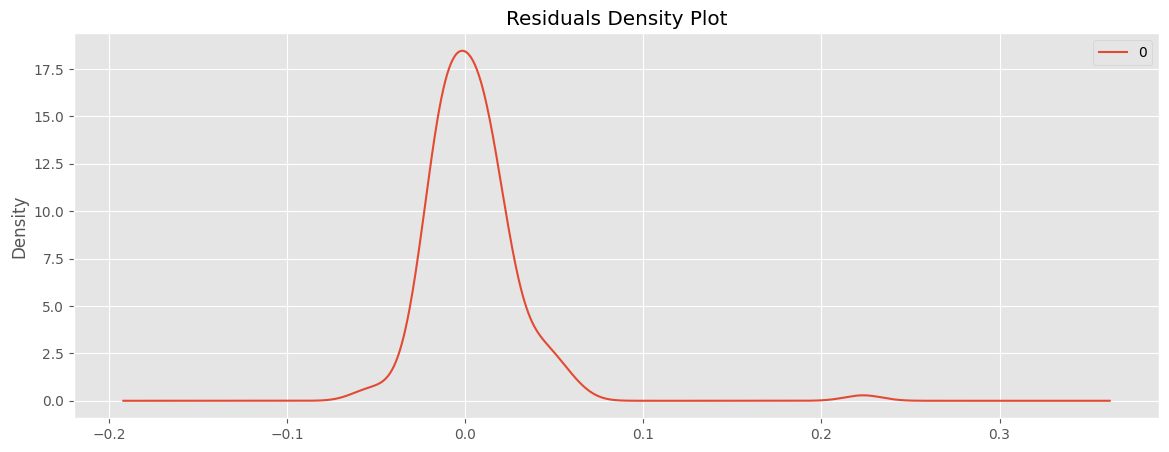

                0
count  132.000000
mean     0.004268
std      0.027836
min     -0.053428
25%     -0.011825
50%      0.002526
75%      0.013859
max      0.223423


In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_1stgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -2.840358
p-value                          0.052736
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [ ]:
print(f'{round(find_rmse(model_1stgrd),4)}')

0.0281


### Cross Validation

In [ ]:
train_with_ind = train_nat_gas.reset_index()

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    #fitting on the train from the train-validation split
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(8, 1, 2)).fit()
    #predicting on the validation part of the sample
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    #comparing validation and predictions on validation
    print(np.sqrt(mean_squared_error(true, preds)))

0.010581504266555746
0.03376251369486834
0.015588312004579158
0.06399910387912713
0.06226135311807862


In [ ]:
print(round(np.mean(cv),4))

0.036


In [ ]:
p_values = [8, 10, 12, 20]
d_values = [1, 2, 4]
q_values = [1, 2, 4]
warnings.filterwarnings("ignore")
evaluate_models_aic(train_nat_gas.values, p_values, d_values, q_values)

ARIMA(8, 1, 1) AIC=-681.832
ARIMA(8, 1, 2) AIC=-697.834
ARIMA(8, 1, 4) AIC=-676.025
ARIMA(8, 2, 1) AIC=-678.780
ARIMA(8, 2, 2) AIC=-692.254
ARIMA(8, 2, 4) AIC=-674.791
ARIMA(8, 4, 1) AIC=-542.396
ARIMA(8, 4, 2) AIC=-598.812
ARIMA(8, 4, 4) AIC=-614.215
ARIMA(10, 1, 1) AIC=-685.284
ARIMA(10, 1, 2) AIC=-716.178
ARIMA(10, 1, 4) AIC=-701.667
ARIMA(10, 2, 1) AIC=-680.196
ARIMA(10, 2, 2) AIC=-699.939
ARIMA(10, 2, 4) AIC=-720.226
ARIMA(10, 4, 1) AIC=-613.270
ARIMA(10, 4, 2) AIC=-588.154
ARIMA(10, 4, 4) AIC=-632.420
ARIMA(12, 1, 1) AIC=-755.815
ARIMA(12, 1, 2) AIC=-756.799
ARIMA(12, 1, 4) AIC=-755.574
ARIMA(12, 2, 1) AIC=-747.735
ARIMA(12, 2, 2) AIC=-729.876
ARIMA(12, 2, 4) AIC=-743.989
ARIMA(12, 4, 1) AIC=-615.025
ARIMA(12, 4, 2) AIC=-627.304
ARIMA(12, 4, 4) AIC=-660.663
ARIMA(20, 1, 1) AIC=-753.947
ARIMA(20, 1, 2) AIC=-755.025
ARIMA(20, 1, 4) AIC=-751.686
ARIMA(20, 2, 1) AIC=-738.353
ARIMA(20, 2, 2) AIC=-732.070
ARIMA(20, 2, 4) AIC=-723.288
ARIMA(20, 4, 1) AIC=-592.830
ARIMA(20, 4, 2) AIC=-66

In [ ]:
model_2ndgrd = ARIMA(train_nat_gas, order=(8, 4, 1)).fit()

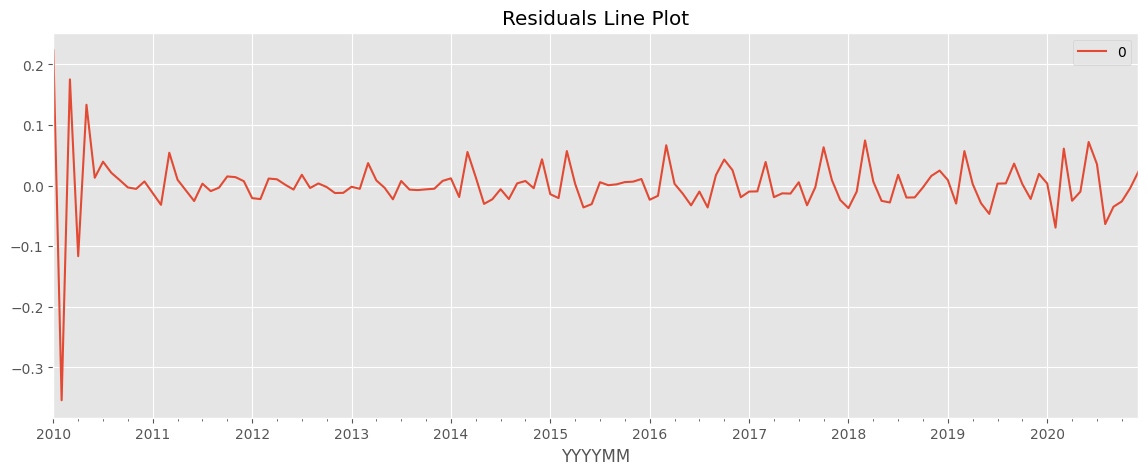

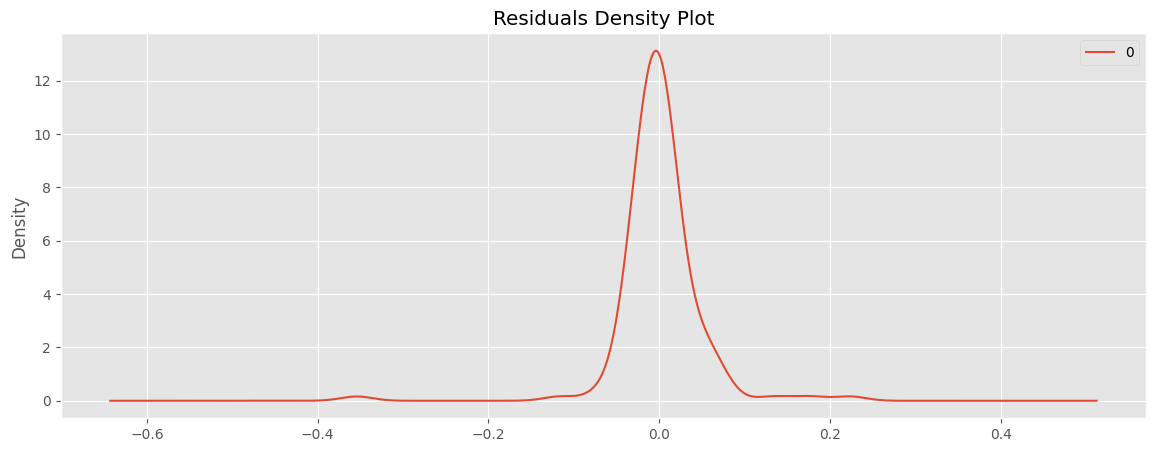

                0
count  132.000000
mean     0.000837
std      0.049782
min     -0.354157
25%     -0.019111
50%     -0.002501
75%      0.011740
max      0.223423


In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_2ndgrd.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.692970e+00
p-value                        4.065590e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


In [ ]:
print(f'{Fore.BLUE}The RMSE for the best ARMA model after first grid, on the train, is in Qa Btu: {round(find_rmse(model_2ndgrd),2)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train, is in Qa Btu: 0.05


Cross Validation

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(12, 1, 4)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

0.019735624245068063
0.022410757317868492
0.015101416342244767
0.0681782164993922
0.01703831559059244


In [ ]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in Qa Btu is: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation in Qa Btu is: 0.03


In [ ]:
from colorama import Fore
from colorama import Style

SARIMAX model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
ARIMA (1, 1, 1) x (1, 4, 2, 12): AIC Calculated=12.0

In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

In [ ]:
ans_df.to_pickle("./SARgrid1.pkl")

In [ ]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  

In [ ]:
res_grid_df.sort_values(by='aic').head(10)

Best model after grid search

In [ ]:
SARIMA_MODEL1 =SARIMAX(train_nat_gas, 
                        order=(8, 2, 2), 
                        seasonal_order=(8, 4, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model and print results
output1 = SARIMA_MODEL1.fit()

In [ ]:
output1.summary()

In [ ]:
y_hat_test = output2.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
y_hat_train = output2.get_prediction(start=pd.to_datetime('2001-01-01'), \
                        end=pd.to_datetime('2018-03-01'), dynamic=False, full_results=True)
pred_conf=y_hat_test.conf_int()

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(output1.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Cross Validation

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 2, 2), 
                    seasonal_order=(8, 4, 1, 12), 
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

In [ ]:
Second Grid Search SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [8, 12]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""CODE used for the second grid search

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_nat_gas,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
ans_df.to_pickle("./SARgs.pkl")

In [ ]:
results_df = pd.read_pickle("./SARgs.pkl")  

In [ ]:
results_df.sort_values(by='aic').head(10)

Best SARIMAX model 2nd grid search

In [ ]:
SARIMA_MODEL2 = SARIMAX(train, 
                        order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                        enforce_stationarity=True, 
                        enforce_invertibility=True)

# Fit the model and print results
output2 = SARIMA_MODEL2.fit()

output2.summary().tables[1]

In [ ]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=round(np.sqrt(mean_squared_error(train, y_hat_train2)),2)
print(f'{Fore.BLUE}RMSE of SARIMA model after second grid search : TWh {RMSE_train2}{Style.RESET_ALL}')

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(output2.resid)
residuals.plot()
plt.title('Residuals Line Plot')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('Residuals Density Plot')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Cross Validation

In [ ]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                     enforce_stationarity=True,
                     enforce_invertibility=True).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
mean=round(np.mean(cv),2)
print(f'{Fore.GREEN}Mean of RMSE after cross validation in TWh: {mean}{Style.RESET_ALL}')

Prediction on the test

fix dates

In [ ]:
y_hat_test = output2.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
y_hat_train = output2.get_prediction(start=pd.to_datetime('2001-01-01'), \
                        end=pd.to_datetime('2018-03-01'), dynamic=False, full_results=True)
pred_conf=y_hat_test.conf_int()

In [ ]:
nat_cut=nat['2010-01-01':]

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.plot(y_hat_test.predicted_mean, label='test_pred', color='b')
ax.plot(nat_cut, label='original data', color='g')
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")
plt.legend(loc='upper left');

In [ ]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='original data', color='g')
ax.plot(y_hat_test.predicted_mean, label='test pred', color='b')
plt.title('Natural Gas energy production, predictions on the Test Set')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Generation (TWh)")
plt.legend();

RMSE on test

In [225]:
coal_prod = production_df[['YYYYMM','Coal Production']]
coal_prod = coal_prod[~(coal_prod['YYYYMM'] % 100 == 13)]
coal_prod['YYYYMM'] = pd.to_datetime(coal_prod['YYYYMM'], format='%Y%m')
coal_prod['Coal Production'] = coal_prod['Coal Production'].astype(float)
coal_prod.set_index('YYYYMM', inplace = True)
coal_prod = coal_prod[coal_prod.index >= '2010-01-01']


cutoff_coal = round(coal_prod.shape[0]*0.8)

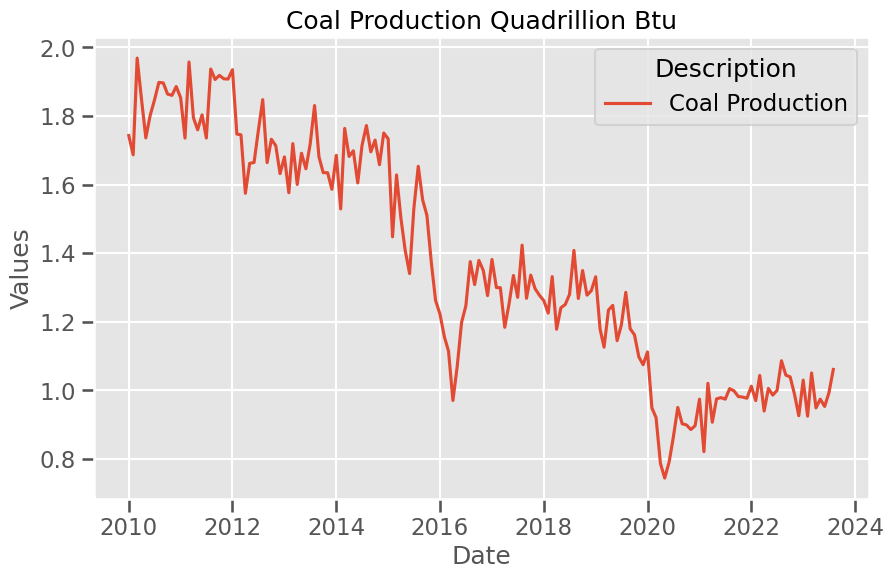

In [256]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=coal_prod)
plt.title("Coal Production Quadrillion Btu")
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [257]:
train_coal = coal_prod[:(cutoff_coal+1)] 
test_coal = coal_prod[cutoff_coal:]
test_coal = test_coal.astype(float)

Text(0, 0.5, 'Production Quadrillion Btu')

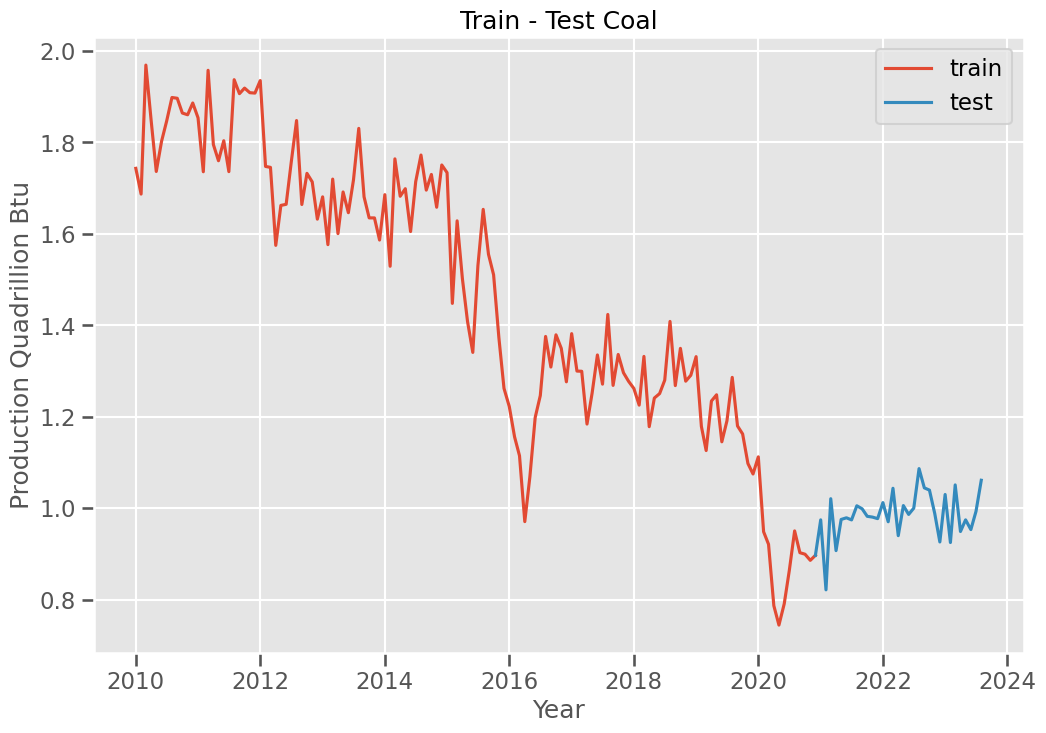

In [258]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_coal, label='train')
ax.plot(test_coal, label='test')
ax.set_title('Train - Test Coal')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Production Quadrillion Btu")

Crude Oil projections

In [259]:
crude_prod = production_df[['YYYYMM','Crude Oil Production']]
crude_prod = crude_prod[~(crude_prod['YYYYMM'] % 100 == 13)]
crude_prod['YYYYMM'] = pd.to_datetime(crude_prod['YYYYMM'], format='%Y%m')
crude_prod['Crude Oil Production'] = crude_prod['Crude Oil Production'].astype(float)
crude_prod.set_index('YYYYMM', inplace = True)
crude_prod = crude_prod[crude_prod.index >= '2010-01-01']



cutoff_crude = round(crude_prod.shape[0]*0.8)


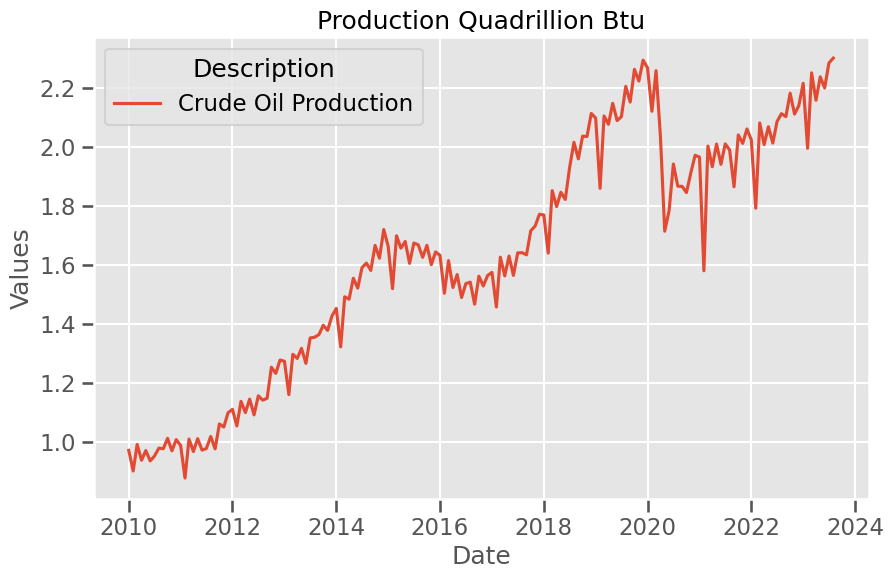

In [260]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=crude_prod)
plt.title("Production Quadrillion Btu")
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [261]:
train_crude = crude_prod[:(cutoff_crude+1)] 
test_crude = crude_prod[cutoff_crude:]
test_crude = test_crude.astype(float)


Text(0, 0.5, 'Generation (TWh)')

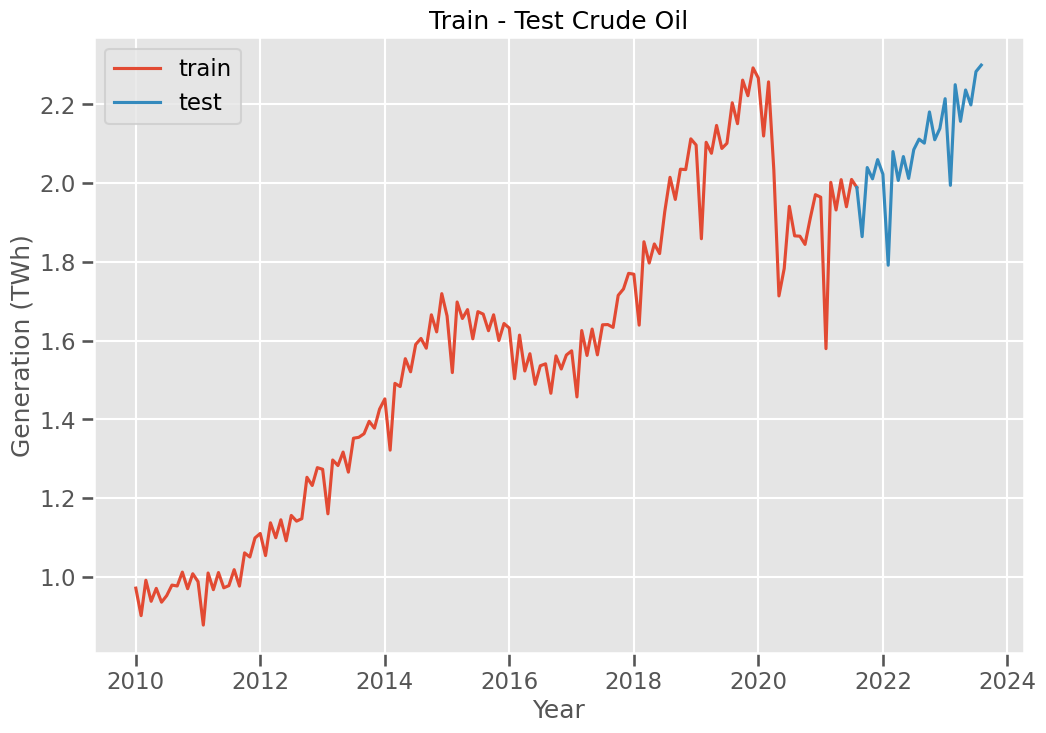

In [246]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_crude, label='train')
ax.plot(test_crude, label='test')
ax.set_title('Train - Test Crude Oil')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Generation (TWh)")

In [236]:
US_total_copy = US_total.reset_index().copy()
US_total_pivot = US_total_copy.pivot(index = 'DATE', columns='ENERGY SOURCE',values = 'Generation (TWh)').reset_index()

<Axes: xlabel='DATE'>

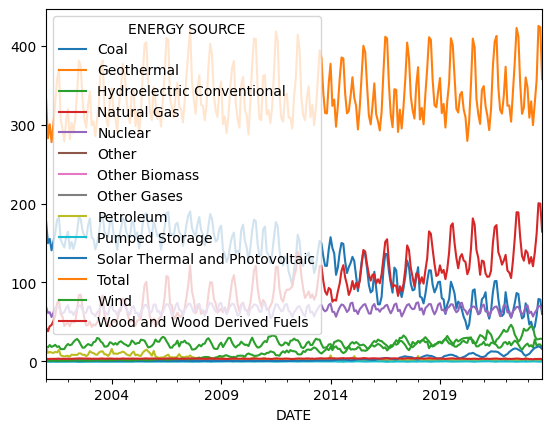

In [241]:
US_total_pivot.set_index('DATE').plot()

In [240]:
US_total_pivot

ENERGY SOURCE,DATE,Coal,Geothermal,Hydroelectric Conventional,Natural Gas,Nuclear,Other,Other Biomass,Other Gases,Petroleum,Pumped Storage,Solar Thermal and Photovoltaic,Total,Wind,Wood and Wood Derived Fuels
0,2001-01-01,177.287111,1.229325,18.852048,42.388663,68.707077,0.991669,1.208647,0.718442,18.111843,-0.588626,0.006500,332.493160,0.389250,3.191212
1,2001-02-01,149.735484,1.073044,17.472889,37.966927,61.272407,0.871949,1.096331,0.675659,10.341503,-0.706956,0.012568,282.940198,0.431242,2.697151
2,2001-03-01,155.269011,1.190023,20.477189,44.364414,62.140712,0.931155,1.189040,0.769181,11.733006,-0.773345,0.031498,300.706544,0.532120,2.852540
3,2001-04-01,140.670654,1.094991,18.012994,45.842746,56.003026,0.957456,1.187239,0.697843,10.863376,-0.795915,0.038759,278.078871,0.684695,2.821007
4,2001-05-01,151.592914,1.071380,19.175635,50.934205,61.512445,0.986268,1.210741,0.784555,10.389988,-0.622526,0.081053,300.491621,0.635029,2.739933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-05-01,43.852224,1.370720,27.479134,137.795292,61.472883,0.857479,1.370367,0.901065,1.188029,-0.450057,16.898529,327.532624,32.018246,2.778714
269,2023-06-01,57.697752,1.272720,19.470633,161.692703,64.965076,0.847597,1.322095,0.895046,1.288477,-0.542346,17.601367,356.672385,27.505935,2.655331
270,2023-07-01,78.909857,1.303275,21.237808,200.506759,69.887588,0.870218,1.362801,0.995442,1.669222,-0.648394,18.841492,425.611328,27.867909,2.807352
271,2023-08-01,78.184501,1.340519,21.145866,199.993042,69.744023,0.814881,1.353127,1.151372,1.690722,-0.644043,17.765584,423.934257,28.504167,2.890496


In [196]:
sp500_url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=979776000&period2=1696032000&interval=1mo&events=history&includeAdjustedClose=true'
sp500 = pd.read_csv(sp500_url)

In [ ]:
global_weather_url = ''

In [197]:
sp500

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-02-01,1366.010010,1376.380005,1215.439941,1239.939941,1239.939941,21644400000
1,2001-03-01,1239.939941,1267.420044,1081.189941,1160.329956,1160.329956,27806610000
2,2001-04-01,1160.329956,1269.300049,1091.989990,1249.459961,1249.459961,25409990000
3,2001-05-01,1249.459961,1315.930054,1232.000000,1255.819946,1255.819946,24525900000
4,2001-06-01,1255.819946,1286.619995,1203.030029,1224.380005,1224.380005,24748030000
...,...,...,...,...,...,...,...
267,2023-05-01,4166.790039,4231.100098,4048.280029,4179.830078,4179.830078,88929200000
268,2023-06-01,4183.029785,4458.479980,4171.640137,4450.379883,4450.379883,87983140000
269,2023-07-01,4450.479980,4607.069824,4385.049805,4588.959961,4588.959961,75063200000
270,2023-08-01,4578.830078,4584.620117,4335.310059,4507.660156,4507.660156,86840820000


In [24]:
gdp_url = "https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv"
destination_folder = 'LOCAL DATA\GDP'
csv_file_name = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_6224532.csv'

def download_gdp_data(gdp_url, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    response = requests.get(gdp_url)
    if response.status_code == 200:
        zip_content = io.BytesIO(response.content)

        with zipfile.ZipFile(zip_content, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        
        print(f"Download and extraction completed. Files are in: {destination_folder}")
    else:
        print(f"Failed to download the zip file. Status code: {response.status_code}")

def download_gdp_data(folder_path, csv_file_name):
    csv_file_path = os.path.join(folder_path, csv_file_name)

    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path, skiprows=4)
        return df
    else:
        print(f"CSV file '{csv_file_name}' not found in the specified folder.")
        return None

    
download_gdp_data(gdp_url, destination_folder)

gdp_df = download_gdp_data(destination_folder, csv_file_name)
gdp_df = gdp_df.set_index(gdp_df.columns[0]).transpose()['United States'].iloc[44:66]
gdp_df = pd.DataFrame(gdp_df).reset_index()
gdp_df.columns = ['year','GDP']
gdp_df['year'] = pd.to_datetime(gdp_df['year'])
gdp_df = gdp_df.infer_objects()



CSV file 'LOCAL DATA\GDP' not found in the specified folder.


Power generation data

In [33]:
from EIA_DATA.generation_data import get_generation_data

In [34]:
raw_gneration_df = get_generation_data()

Power Plant data

In [29]:
from EIA_DATA.plant_data import get_plant_data

In [30]:
raw_plant_df = get_plant_data()

Successfully downloaded and unzipped https://www.eia.gov/electricity/data/eia860/xls/eia8602022.zip


## Clean the data

### First the generation data

When we got the data from the excel file it grabbed rows above the headers. We can find all values in the 'YEAR' column and remove them from the dataframe. We can also remove rows that have values that are NaN. We can also check the integrity of the data by looking for duplicate rows. 

In [35]:
invalid_rows = raw_gneration_df[raw_gneration_df['YEAR'].str.isnumeric() == False]
gen_df = raw_gneration_df.drop(invalid_rows.index).dropna()
gen_df.duplicated().sum()



0

To ensure we didn't have change our data too much we check the shape of the dataframe before and after.

In [36]:
print("Shape of raw_df:")
print(raw_gneration_df.shape)

print("\nShape of df:")
print(gen_df.shape)

removed_rows = raw_gneration_df.shape[0] - gen_df.shape[0]
print(f'We removed {removed_rows} row(s).')

Shape of raw_df:
(530838, 6)

Shape of df:
(530790, 6)
We removed 48 row(s).


We can change the date types to make our data easier to work with. Then check what they are after we have changed them.

In [37]:
gen_df = gen_df.infer_objects()
gen_df.dtypes


YEAR                            int64
MONTH                           int64
STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

We want to take the year and month columns and convert them into a date colum we can use to index the dataframe. We dont have a day of the month so we just use a constant value of 1. We can not get rid of the year and month columns to clean up the dataframe. We also want to infer objects again because we changed the headers and added a datetime column.

In [38]:
gen_df['DATE'] = pd.to_datetime(gen_df[['YEAR', 'MONTH']].assign(day=1),errors='coerce')
gen_df.set_index('DATE', inplace=True)
gen_df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
gen_df.head()

gen_df = gen_df.infer_objects()
gen_df.dtypes


STATE                          object
TYPE OF PRODUCER               object
ENERGY SOURCE                  object
GENERATION (Megawatthours)    float64
dtype: object

Converting the 'STATE' column to uppercase ensures a consistent and standardized representation of state names.

In [39]:
gen_df['STATE'] = gen_df['STATE'].str.upper()

The unit Megawatt-hours (MWh) is very small when dealing with net generation so we will reduce it to make it more manageable. We are going to use a Terawatt-hour (TWh) which is equal to 1 million Megawatt-hours. For reference the average house hold uses 10,632 kilowatt-hours per year or .00001063 TWh.

In [40]:
gen_df["Generation (TWh)"] = gen_df["GENERATION (Megawatthours)"]/1000000
gen_df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)

### Now the power plant data

In [37]:
raw_plant_df.columns

Index(['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name', 'State',
       'County', 'Generator ID', 'Technology', 'Prime Mover', 'Unit Code',
       'Ownership', 'Duct Burners',
       'Can Bypass Heat Recovery Steam Generator?',
       'RTO/ISO LMP Node Designation',
       'RTO/ISO Location Designation for Reporting Wholesale Sales Data to FERC',
       'Nameplate Capacity (MW)', 'Nameplate Power Factor',
       'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Minimum Load (MW)',
       'Uprate or Derate Completed During Year',
       'Month Uprate or Derate Completed', 'Year Uprate or Derate Completed',
       'Status', 'Synchronized to Transmission Grid', 'Operating Month',
       'Operating Year', 'Planned Retirement Month', 'Planned Retirement Year',
       'Associated with Combined Heat and Power System', 'Sector Name',
       'Sector', 'Topping or Bottoming', 'Energy Source 1', 'Energy Source 2',
       'Energy Source 3', 'Energy Source 4', 'Energy Source 5',
       'Ene

In [38]:
raw_plant_df.duplicated().sum()

0

### Make some copies of the data

Now that we have our data cleaned we will make a copy of the data frame to hold entegrity of the data

In [39]:
raw_df_copy = gen_df.copy()
raw_df_copy.shape

(530790, 4)

We will also make the df into a csv if we need to pull into excel to better understand

In [40]:
raw_plant_df.to_csv('planttest.csv', index=False)

gen_df_reset = gen_df.reset_index()
gen_df_reset.to_csv('net_generation_df.csv', index=True)

# Start of analysis

### Getting to know the data

We need to know more about the gen_df DataFrame to start

To better understand our data we can get all they types of producers and the types of energy sources by using the .unique() method. This will also help us validate that we cleaned the data correctly. 

In [41]:
types_producer = gen_df['TYPE OF PRODUCER'].unique()
types_producer

array(['Total Electric Power Industry',
       'Electric Generators, Electric Utilities',
       'Combined Heat and Power, Electric Power',
       'Combined Heat and Power, Commercial Power',
       'Combined Heat and Power, Industrial Power',
       'Electric Generators, Independent Power Producers'], dtype=object)

In [42]:
gen_df['ENERGY SOURCE'].unique()

array(['Coal', 'Petroleum', 'Natural Gas', 'Hydroelectric Conventional',
       'Wind', 'Total', 'Other Gases', 'Nuclear',
       'Wood and Wood Derived Fuels', 'Other Biomass', 'Other',
       'Solar Thermal and Photovoltaic', 'Pumped Storage', 'Geothermal'],
      dtype=object)

We can check on 'GENERATION (Twh)' column and get some statistics that will describe our dataset. 

In [43]:
gen_df['Generation (TWh)'].describe()

count    530790.000000
mean          1.390318
std          10.785769
min          -0.997855
25%           0.001574
50%           0.022916
75%           0.277950
max         425.611328
Name: Generation (TWh), dtype: float64

We see that our standard diviation is very high and there is a large gap between the percentiles. This tell us that there is many outliers and values that are zero. Anohter thing to note is that the min value is a negitive number. This is data on the generaion of electiricy so we went to know why type of energy source is pulling power instead of producing it. 

We can plot a histogram to see how the data is distributed and get a visual representation. 

<Axes: >

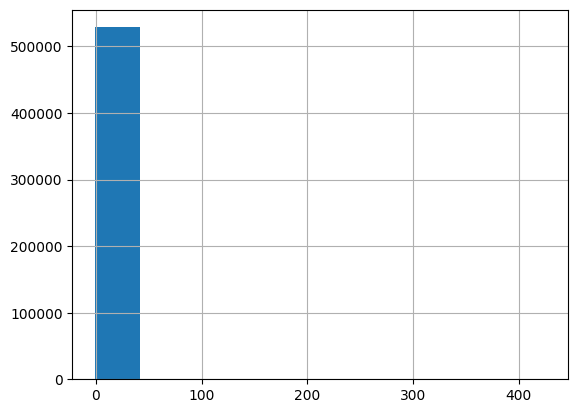

In [44]:
gen_df['Generation (TWh)'].hist()
#come back and add label and a title


The visual representation validates our observations from the describe() table, indicating a concentration of values around zero and notable outliers at the upper end. However, it's important to note that this graph represents a broad overview, encompassing diverse sources, states, and their totals spanning from 2001 to 2023. To narrow our focus and derive more targeted insights, we plan to apply filters, selecting specific subsets of data such as totals, specific sources, or particular states for further analysis.

In [44]:
gen_df['TYPE OF PRODUCER'].value_counts()


TYPE OF PRODUCER
Total Electric Power Industry                       143564
Electric Generators, Electric Utilities             100222
Electric Generators, Independent Power Producers     95985
Combined Heat and Power, Industrial Power            82955
Combined Heat and Power, Commercial Power            58112
Combined Heat and Power, Electric Power              49952
Name: count, dtype: int64

We can see there are really three categories in the producer columns. 
- Electric Generators
- Combined Heat and Power
- Total Electric Power Industry

Each have a subcategory too.

We can now do the same for the plant_df DataFrame

# Key research areas

## Total US power generation by month

#### Understanding the Total electric power generation

We will start our analysis on the 'Total Electric Power Industry' to begin

Totals are already calculated in the df so we will just need to pull the right columns.

In [45]:
total=gen_df.loc[gen_df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=total.loc[total['STATE']=='US-TOTAL']
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [47]:
US_source

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
1,2001-01-01,Geothermal,US-TOTAL,Total Electric Power Industry,1.229325
2,2001-01-01,Hydroelectric Conventional,US-TOTAL,Total Electric Power Industry,18.852048
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
...,...,...,...,...,...
3817,2023-09-01,Pumped Storage,US-TOTAL,Total Electric Power Industry,-0.543781
3818,2023-09-01,Solar Thermal and Photovoltaic,US-TOTAL,Total Electric Power Industry,15.529558
3819,2023-09-01,Total,US-TOTAL,Total Electric Power Industry,358.136260
3820,2023-09-01,Wind,US-TOTAL,Total Electric Power Industry,28.193292


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


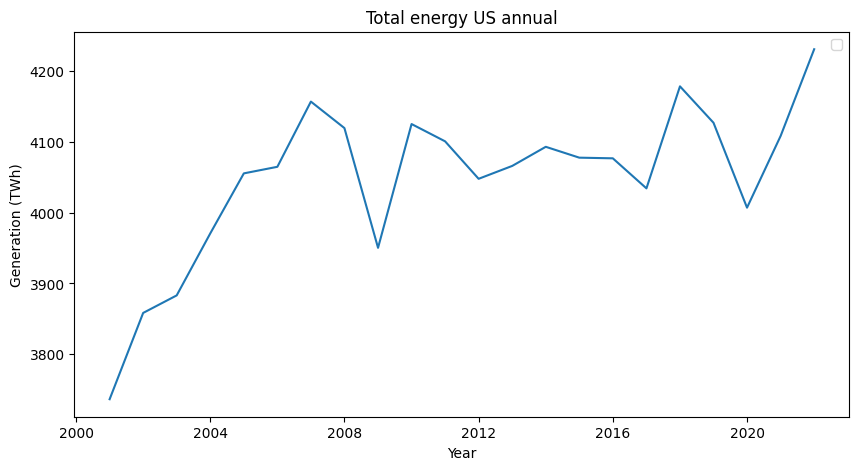

In [48]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

US_total_year = US_total_month.groupby(US_total_month['DATE'].dt.year, as_index=False).agg({'DATE': 'first', 'Generation (TWh)': 'sum'})

US_total_year = US_total_year[US_total_year['DATE'].dt.year != 2023]

plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_total_year, x=US_total_year['DATE'] \
             ,y=US_total_year['Generation (TWh)'])
plt.title("Total energy US annual")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [49]:
US_total_year

,DATE,Generation (TWh)
0,2001-01-01,3736.643649
1,2002-01-01,3858.452251
2,2003-01-01,3883.185204
3,2004-01-01,3970.555264
4,2005-01-01,4055.422750
5,2006-01-01,4064.702227
6,2007-01-01,4156.744725
7,2008-01-01,4119.387759
8,2009-01-01,3950.330927
9,2010-01-01,4125.059899


In [50]:
US_total_year

,DATE,Generation (TWh)
0,2001-01-01,3736.643649
1,2002-01-01,3858.452251
2,2003-01-01,3883.185204
3,2004-01-01,3970.555264
4,2005-01-01,4055.422750
5,2006-01-01,4064.702227
6,2007-01-01,4156.744725
7,2008-01-01,4119.387759
8,2009-01-01,3950.330927
9,2010-01-01,4125.059899


In [51]:
# add growth rates per year and trend line

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


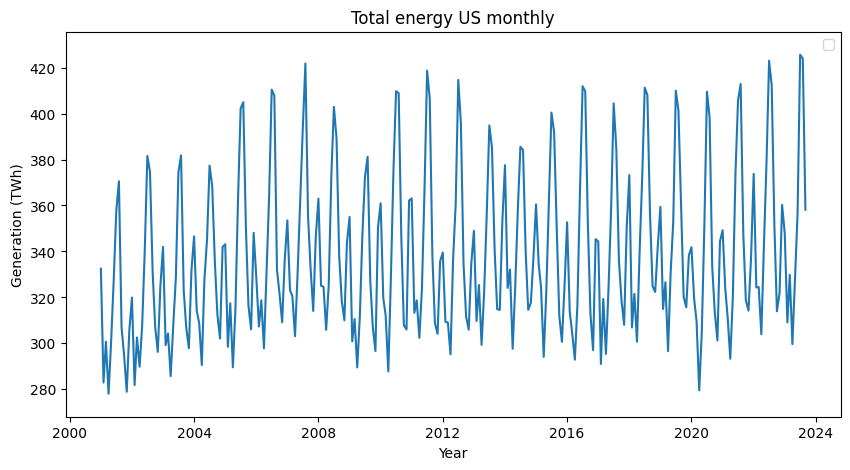

In [52]:
US_total_month=US_source[(US_source['ENERGY SOURCE']=='Total')]

plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_total_month, x=US_total_month['DATE'] \
             ,y=US_total_month['Generation (TWh)'])
plt.ylim(US_total_month['Generation (TWh)'].min() - 10, US_total_month['Generation (TWh)'].max() + 10) 
plt.title("Total energy US monthly")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

## Energy Production by state

Now that we have looked at the totals we want to look net generation by state. So we dont double count any values we will make a DataFrame that is the inverse of the totals DataFrame by taking out all of the US-Total values. 

Similar to how we separated the totals from the rest of the data we will pull totals out so we dont double count when we group by states

In [53]:
state_df = gen_df[(gen_df['STATE'] != 'US-TOTAL') & 
              (gen_df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (gen_df['ENERGY SOURCE'] == 'Total')]

Make some more DataFrames by grouping by states: month year and all-time

In [54]:
state_total_month =state_df.groupby(by=[state_df.index,"STATE"]).sum().reset_index()
state_total_year =state_df.groupby(by=[state_df.index.year,"STATE"]).sum().reset_index()
state_total_alltime =state_df.groupby(by=["STATE"]).sum().reset_index().sort_values(by='Generation (TWh)')
state_total_alltime.shape

(51, 4)

By sorting the values we can see the state that has produced the most electricity in the last 22 years cumulative.

In [55]:
TimePeriodOfData = (state_df.index.year.unique().max()) - (state_df.index.year.unique().min())
TimePeriodOfData

22

In [56]:
state_total_month_top10=state_total_alltime[['STATE','Generation (TWh)']].sort_values(by='Generation (TWh)', ascending=False).iloc[:10]
state_total_month_top10[['STATE','Generation (TWh)']]

,STATE,Generation (TWh)
43,TX,9894.888992
9,FL,5218.290742
38,PA,5036.201059
4,CA,4568.488753
14,IL,4341.616358
1,AL,3261.197689
35,OH,3109.237906
34,NY,3088.521236
10,GA,2930.871739
27,NC,2882.807861


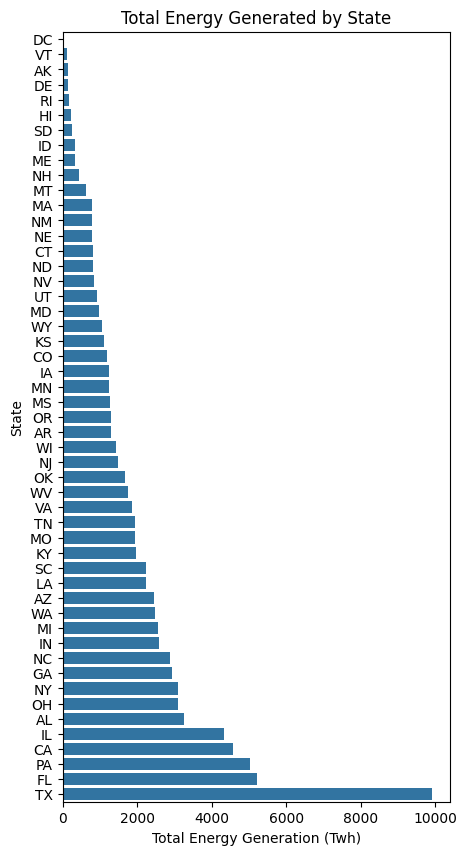

In [57]:
plt.figure(figsize=(5, 10))
sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_alltime,errorbar=None)
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State')

plt.show()

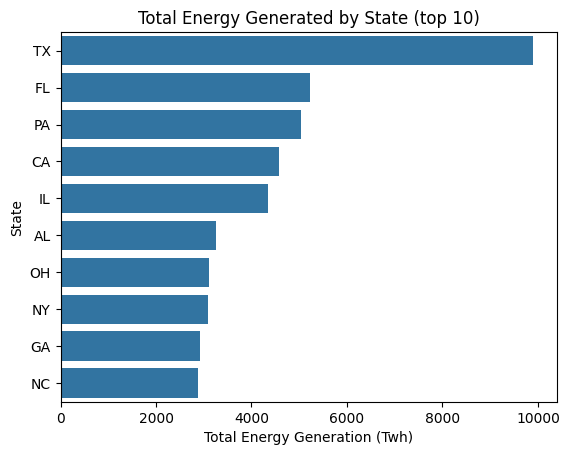

In [58]:
state_total_alltime['AVG Generation'] = state_total_alltime['Generation (TWh)']/TimePeriodOfData
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Generation (TWh)']/state_total_alltime['Generation (TWh)'].sum())
state_total_alltime['Percent of total US generation'] = (state_total_alltime['Percent of total US generation'] * 100).map("{:.2f}%".format)


state_total_alltime[['STATE','Generation (TWh)','AVG Generation','Percent of total US generation']].sort_values(by= 'Generation (TWh)',ascending = False).head(5)

sns.barplot(x='Generation (TWh)', y='STATE', data=state_total_month_top10,errorbar=None)
sns.color_palette("tab10")
plt.xlabel('Total Energy Generation (Twh)')
plt.ylabel('State')
plt.title('Total Energy Generated by State (top 10)')

plt.show()

In [59]:
# change these over to heat maps

In [60]:
type_producer_year['TYPE OF PRODUCER'].unique()

NameError: name 'type_producer_year' is not defined

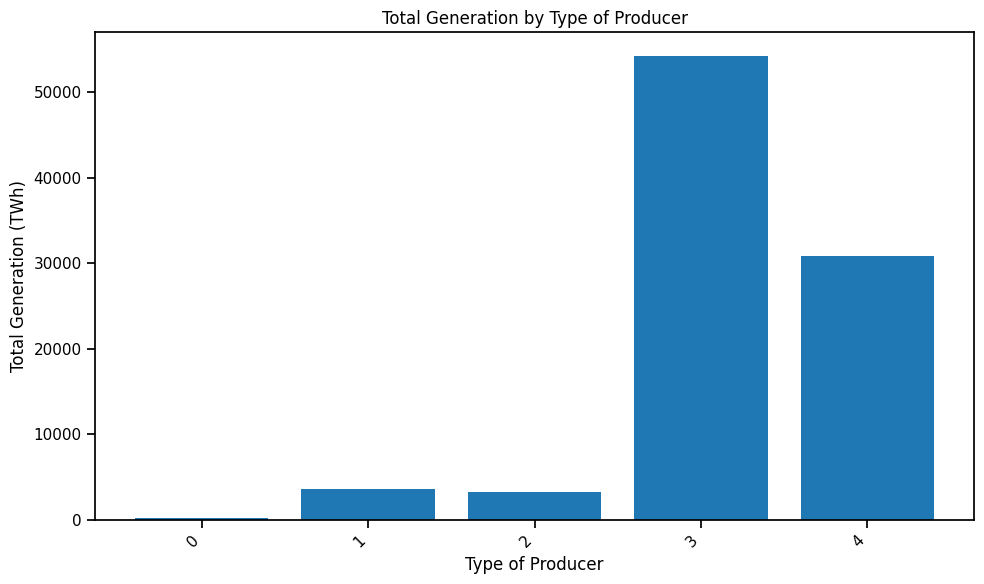

In [ ]:
type_producer = gen_df[(gen_df['STATE'] == 'US-TOTAL') & 
              (gen_df['TYPE OF PRODUCER'] != 'Total Electric Power Industry') & 
              (gen_df['ENERGY SOURCE'] == 'Total')].reset_index()

type_producer_year = type_producer.groupby(by = type_producer['TYPE OF PRODUCER']).sum('Generation (TWh)').reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_producer_year.index, type_producer_year['Generation (TWh)'])
plt.xlabel('Type of Producer')
plt.ylabel('Total Generation (TWh)')
plt.title('Total Generation by Type of Producer')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

Might want to add per capita data and graph it againt the total generation. 

## Energy Sources

In [ ]:
US_source_no_total=US_source[(US_source['ENERGY SOURCE']!='Total')]
US_source_no_total[['DATE','ENERGY SOURCE','Generation (TWh)']].sort_values(by = 'Generation (TWh)', ascending= False).head()

,DATE,ENERGY SOURCE,Generation (TWh)
3783,2023-07-01,Natural Gas,200.506759
3797,2023-08-01,Natural Gas,199.993042
1106,2007-08-01,Coal,190.134816
938,2006-08-01,Coal,189.454930
3615,2022-07-01,Natural Gas,189.042160


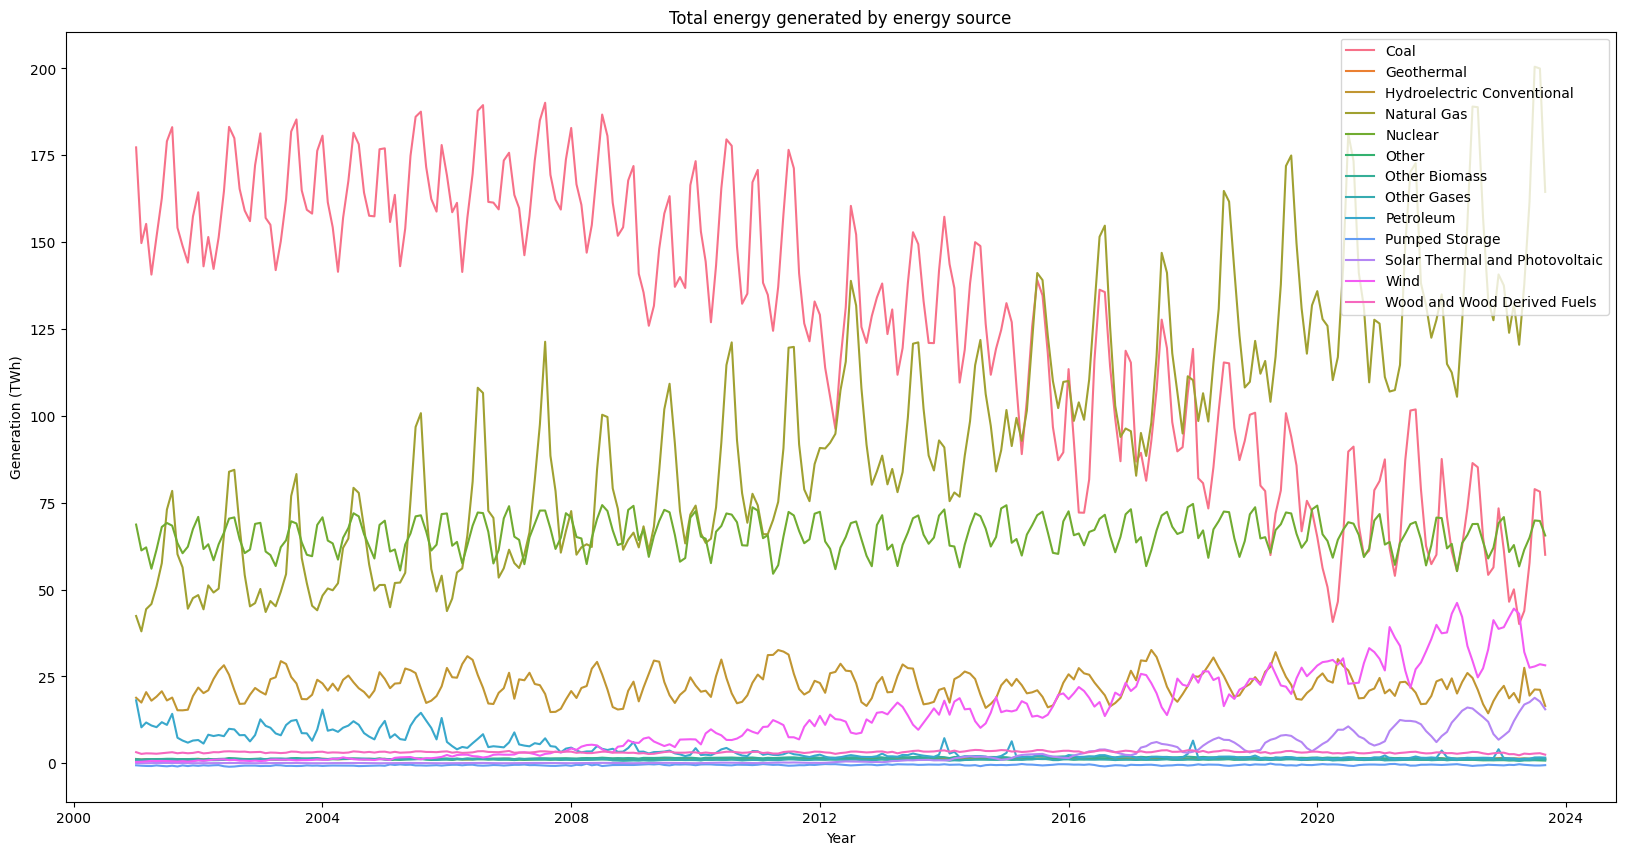

In [ ]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_source_no_total, x=US_source_no_total['DATE'] \
             ,y=US_source_no_total['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by energy source")
plt.xlabel("Year")
plt.legend(loc='best')
plt.show()

In [ ]:
#Trent add bar here

This chart is very busy so we can break down the energy sources into three groups High Med and Small

In [ ]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]
US_top3.head()

,DATE,ENERGY SOURCE,STATE,TYPE OF PRODUCER,Generation (TWh)
0,2001-01-01,Coal,US-TOTAL,Total Electric Power Industry,177.287111
3,2001-01-01,Natural Gas,US-TOTAL,Total Electric Power Industry,42.388663
4,2001-01-01,Nuclear,US-TOTAL,Total Electric Power Industry,68.707077
14,2001-02-01,Coal,US-TOTAL,Total Electric Power Industry,149.735484
17,2001-02-01,Natural Gas,US-TOTAL,Total Electric Power Industry,37.966927


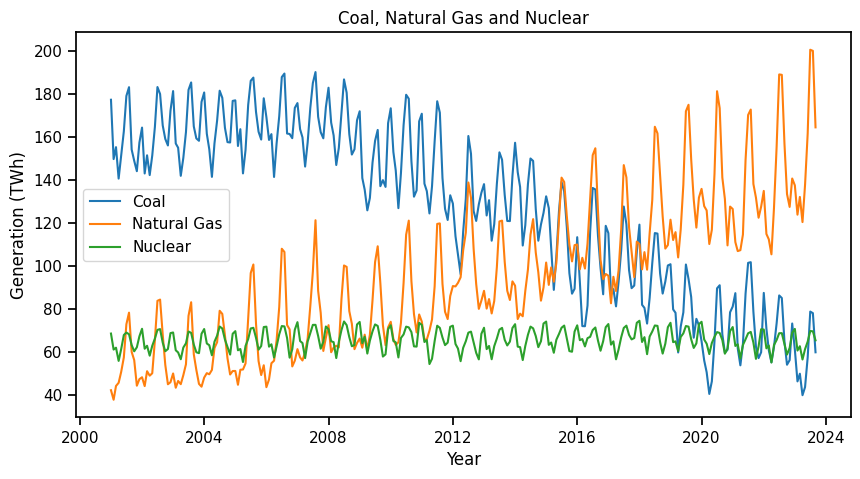

In [ ]:
plt.figure(figsize=(10,5))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['DATE'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Coal, Natural Gas and Nuclear")
plt.xlabel("Year")
plt.legend(loc='best')

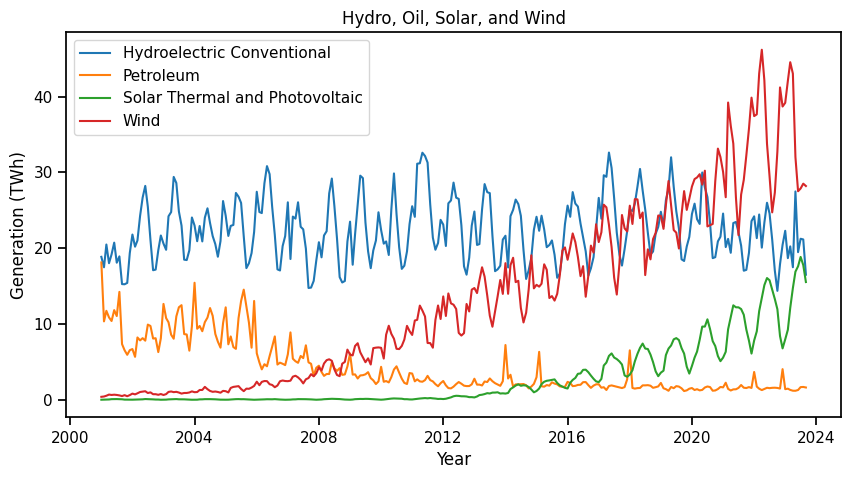

In [ ]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

plt.figure(figsize=(10,5))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['DATE'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Hydro, Oil, Solar, and Wind")
plt.xlabel("Year")
plt.legend(loc='best')

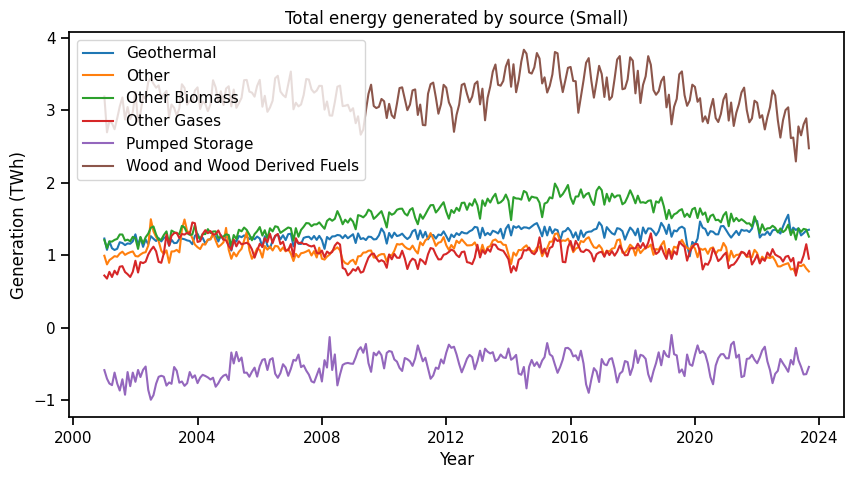

In [ ]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

plt.figure(figsize=(10,5))
sns.color_palette("deep")
sns.lineplot(data=US_bot, x=US_bot['DATE'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by source (Small)")
plt.xlabel("Year")
plt.legend(loc='upper left')

We can also look at look at the three that look to be growing the most, Natrual gas, wind, and solar.

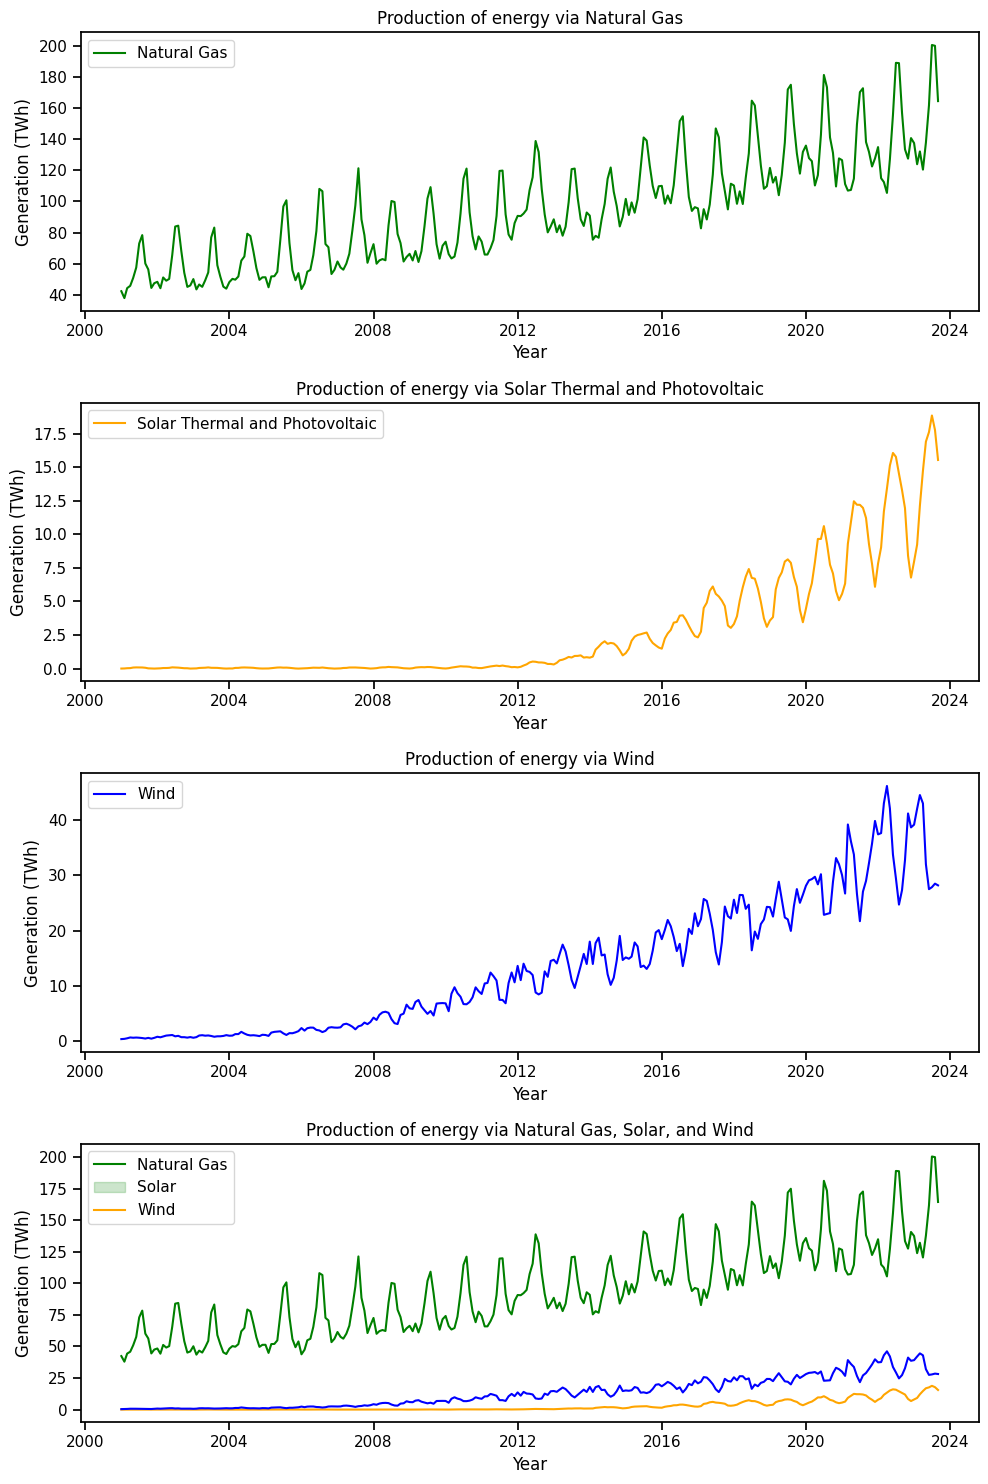

In [ ]:
sns.set_context("notebook")
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

def plot_energy_source(ax, df, energy_source, color):
    source_data = df.loc[df['ENERGY SOURCE'] == energy_source]
    sns.lineplot(x=source_data.index, y=source_data['Generation (TWh)'], color=color, ax=ax)
    ax.set_title(f'Production of energy via {energy_source}')
    ax.set_xlabel("Year")
    ax.set_ylabel("Generation (TWh)")
    ax.legend([energy_source]) 

plot_energy_source(axs[0], US_total, 'Natural Gas', 'green')
plot_energy_source(axs[1], US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(axs[2], US_total, 'Wind', 'blue')
ax_combined = axs[3]

plot_energy_source(ax_combined, US_total, 'Natural Gas', 'green')
plot_energy_source(ax_combined, US_total, 'Solar Thermal and Photovoltaic', 'orange')
plot_energy_source(ax_combined, US_total, 'Wind', 'blue')

ax_combined.set_title('Production of energy via Natural Gas, Solar, and Wind')
ax_combined.set_xlabel("Year")

ax_combined.legend(['Natural Gas', 'Solar', 'Wind'])

plt.tight_layout()
plt.show()

Who creates the most power? By state? By type of producer?

Plotted by themselves they look to grow very fast but when ploted together solar and windthe make up of net generation 

## Electircal power capacity

### How close is our current generation to our total capacity?

In [ ]:
plant_state_df = raw_plant_df[['Utility Name_x','State_x','Technology','Generator ID','Nameplate Capacity (MW)','Nameplate Power Factor']]
state_capacity = plant_state_df.groupby('State_x').sum('Nameplate Capacity (MW').sort_values(by = ['Nameplate Capacity (MW)'], ascending= False).head()

In [ ]:
plant_state_df['Nameplate Power Factor'].count()

620746

In [ ]:
state_capacity['Nameplate Capacity (MW)'].sum()

13425714.800000003

## Electricity Uses

'https://www.eia.gov/electricity/sales_revenue_price/xls/table_10.xlsx'

If on type goes up do the others fall by a factor

## Renewable Energy Growth by State:

In [ ]:
# Sean add solor data here

## Correlation between Energy Sources:

## Correlation GDP and Total electric production

# Conclusion 